# Data Wrangling and Methods

## 1. Load R packages

In [1]:
# data wrangling/exploration
library(googledrive)
library(readr)
library(tidyr)
library(GGally)
library(googlesheets4)
library(stringr)
# library(pcr) #modified the source code instead

# plotting
library(ggplot2)
library(viridis)
library(ggpubr)
library(ggrepel)   #for text labels on plots

#tables
library(dplyr)
library(stargazer)

#cite
library(knitr)

#modeling
library(broom)

options(jupyter.plot_mimetypes = c("text/plain","image/png"))


Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘googlesheets4’


The following objects are masked from ‘package:googledrive’:

    request_generate, request_make


Loading required package: viridisLite


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 




In [2]:
# sessionInfo()

### Modified PCR package code

In [3]:
#source code from the pcr package for R because I wanted to modify how they calculate R2 to allow NaNs https://github.com/cran/pcr/blob/master/R/analyses_fun.R
.pcr_rsquared <- function(vec, var) {
  ll <- lm(vec ~ log10(var))
  res <-summary(ll)$r.squared 
    # res <- cor(vec, log10(var))^2
  return(res)
}


.pcr_intercept <- function(vec, var) {
  ll <- lm(vec ~ log10(var))
  res <- coefficients(ll)
  return(res[[1]])
}


.pcr_slope <- function(vec, var) {
  ll <- lm(vec ~ log10(var))
  res <- coefficients(ll)
  return(res[[2]])
}

pcr_standard <- function(df, amount, plot = FALSE) {
  # order data.frame and group var
  df <- df[order(amount),]
  amount <- amount[order(amount)]

  # return data when plot is false
  if (plot) {
    gg <- .pcr_plot_assess(df,
                           amount,
                           method = 'standard_curve')

    return(gg)
  } else {
    # calculate trend; intercept, slope and r_squared
    trend <- apply(df,
                   MARGIN = 2,
                   FUN = function(x) {
                     data.frame(
                       gene = '',
                       intercept = .pcr_intercept(x, amount),
                       slope = .pcr_slope(x, amount),
                       r_squared = .pcr_rsquared(x, amount),
                       num_points = sum(!is.na(x))/2,
                       max_ct = round(max(x,na.rm=T),2)
                     )
                   })

    # make a data.frame
    trend <- do.call(rbind, trend)
    trend$gene <- names(df)
    rownames(trend) <- NULL

    return(trend)
  }
}

pcr_assess <- function(df, method = 'standard_curve', ...) {
  switch(method,
         'standard_curve' = pcr_standard(df, ...),
         'efficiency' = pcr_efficiency(df, ...))
}

col_names_all<-c("plate_id", "intercept","slope","r_sq", "num_pts", "max_ct","efficiency")

In [4]:
#my wrapper for qPCR std curve results

std_assess<- function(dfo){
    targs<- unique(dfo$target)
    df_curve_fin<- data.frame()

    for(targ in targs){
        df<-dfo[dfo$target== targ,]
        reg<-unique(df$target_region)
        df<-df[,c("plate_id","quantity", "CT","target")]
        df$num_lab<- +(!duplicated(df[,c("plate_id","quantity")]))
        df$num_lab<-df$num_lab +1
        df$num_lab2<- +(!duplicated(df[,c("plate_id","quantity","num_lab")]))
        df$label<- paste(as.character(df$quantity),as.character(df$num_lab),as.character(df$num_lab2)) #because some are triplicate

        df_wide <- spread(df, plate_id, CT)
        df_wide = df_wide[,(names(df_wide) != "label")]
        df_wide = df_wide[,(names(df_wide) != "num_lab")]
        df_wide = df_wide[,(names(df_wide) != "num_lab2")]
        df_wide = df_wide[,(names(df_wide) != "target")]
        
        # set quantity
        quantity=df_wide$quantity
        df_curve<-pcr_assess(df_wide,amount = quantity,method = 'standard_curve')
        df_curve$efficiency<-round((10^(-1/df_curve$slope)-1)*100,2)
        names(df_curve)<-col_names_all
        df_curve$r_sq<-round(df_curve$r_sq,2)
        df_curve = df_curve[df_curve$plate_id != "quantity",]
        df_curve<-df_curve[,c("plate_id", "intercept","slope","r_sq", "num_pts","efficiency","max_ct")]
        df_curve$target<- targ
        df_curve$target_region<- reg
        df_curve_fin=rbind(df_curve_fin,df_curve)

    }
    return(df_curve_fin)
    
    }



std_assess_master<- function(dfo){
    targs<- unique(dfo$target)
    df_curve_fin<- data.frame()

    for(targ in targs){
        df<-dfo[dfo$target== targ,]
        
        # set quantity
        quantity=df$quantity
        df<-df[,c( "quantity","CT")]
        
        df_curve<-pcr_assess(df,amount = quantity,method = 'standard_curve')
        df_curve$efficiency<-round((10^(-1/df_curve$slope)-1)*100,2)
        names(df_curve)<-col_names_all
        df_curve$r_sq<-round(df_curve$r_sq,2)
        df_curve = df_curve[df_curve$plate_id != "quantity",]
        df_curve<-df_curve[,c("intercept","slope","r_sq", "num_pts","efficiency","max_ct")]
        df_curve$target<- targ
        df_curve_fin=rbind(df_curve_fin,df_curve)

    }
    return(df_curve_fin)
    
    }
    
    

In [5]:
#identify locations of data and figures and tables
path_f=paste(getwd(),"/Figures_and_tables/", sep="")
path_d=paste(getwd(),"/Data/", sep="")

#sizing in mm based on https://www.elsevier.com/authors/author-schemas/artwork-and-media-instructions/artwork-sizing
min_w=30
single.col_w= 90
half.col_w= 140
max_w= 190
max_h=240

## 2. Load & wrangle dataset

In [6]:
#read files
filenames <- list.files(path=path_d,pattern="*csv")

#names without extension
names <-sapply(strsplit(filenames, "\\."), `[`, 1)

# load
for(i in names){
    filepath <- file.path(path_d,paste(i,".csv",sep=""))
    assign(i, read.delim(filepath,sep = ","))
}


## 3. Assay Development

### Assay Development MK

In [7]:
assay_development_MK$target_region<- as.factor(assay_development_MK$target_region)
levels(assay_development_MK$target_region)<-c('Region 1','Region 2','Region 3','Region 4','Region 5','Region 6','Region 7','Region 9','Region 10')

assay_dev_MK_subbed_tog<- assay_development_MK %>%
  group_by(plate_id, quantity, target,target_region) %>%
  summarize(CT_std= as.numeric(sd(CT, na.rm = TRUE)),
            CT_mean = as.numeric(mean(CT, na.rm = TRUE)) )

std_curves_dev_MK<- std_assess(assay_development_MK)
std_curves_dev_MK

std_curves_dev_MK_long<- std_assess(assay_development_MK[,c("target","CT","quantity","plate_id")])

`summarise()` has grouped output by 'plate_id', 'quantity', 'target'. You can
override using the `.groups` argument.


,plate_id,intercept,slope,r_sq,num_pts,efficiency,max_ct,target,target_region
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
2,P1006,39.71972,-3.628104,1.00,5,88.64,34.07,MK1,Region 1
21,P1006,39.35946,-3.576199,1.00,5,90.38,33.62,MK2,Region 3
22,P1006,38.89315,-3.711415,1.00,5,85.97,33.18,MK3,Region 4
23,P1006,37.70170,-3.539822,1.00,5,91.65,32.05,MK4,Region 5
24,P1006,39.21469,-3.829747,0.99,5,82.44,34.39,MK5,Region 6
25,P1007,40.35437,-3.709737,0.99,5,86.02,34.48,MK6,Region 7
26,P1007,39.91762,-3.597174,1.00,5,89.67,34.95,MK7,Region 9
27,P1007,39.74309,-3.608474,0.99,5,89.29,34.30,MK9,Region 10
28,P1007,40.44395,-3.703769,0.99,5,86.21,35.99,MK10,Region 2


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



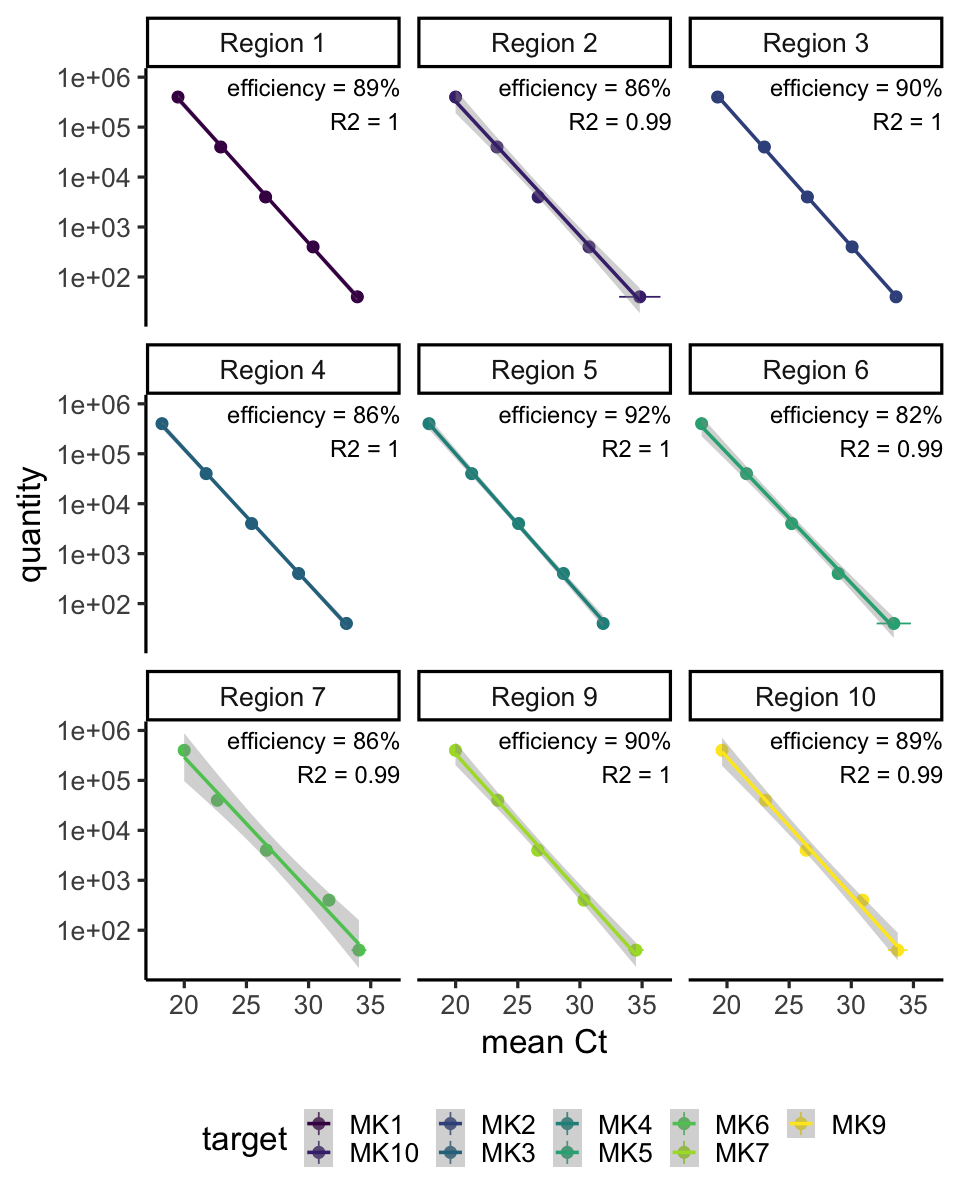

In [8]:
options(repr.plot.width =8, repr.plot.height = 10) #change the size of the plot
theme_set(theme_classic(base_size=20))# set font size

a<-assay_dev_MK_subbed_tog

g<- ggplot(a, aes(x=CT_mean, y=quantity))+
    geom_pointrange(aes(x=CT_mean, y=quantity, xmin= CT_mean -CT_std, xmax= CT_mean +CT_std, color=target ))+
    geom_point(size=3, aes(color=target))+
    geom_smooth(method='lm', aes(color=target))+
    xlab("mean Ct")+
    scale_color_viridis_d()+
    facet_wrap(~target_region)+
    scale_y_log10()+
    theme(legend.position= "bottom")

dfl<-std_curves_dev_MK%>%
mutate(Label=paste("efficiency = ",format(efficiency, digits=0),"%\nR2 = ",r_sq, sep=""))

g + geom_text(data=dfl,aes(x=+Inf,y=+Inf,label=Label),
hjust = 1,vjust=1.2, size=5)

ggsave(paste0(path_f,"Figure_S4.jpg"),  units='mm',device= 'jpg',width=max_w, height=max_h)


### Assay Development OL

In [9]:
assay_development_OL$target_region<- as.factor(assay_development_OL$target_region)

assay_dev_OL_subbed_tog<- assay_development_OL %>%
  group_by(plate_id, quantity, target,target_region, assay_letter) %>%
  summarize(CT_std= as.numeric(sd(CT, na.rm = TRUE)),
            CT_mean = as.numeric(mean(CT, na.rm = TRUE)) )
std_curves_dev_OL<- std_assess(assay_development_OL)
std_curves_dev_OL

std_curves_dev_OL_long<- std_assess(assay_development_OL[,c("target","CT","quantity","plate_id")])

`summarise()` has grouped output by 'plate_id', 'quantity', 'target',
'target_region'. You can override using the `.groups` argument.


,plate_id,intercept,slope,r_sq,num_pts,efficiency,max_ct,target,target_region
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
2,P87,38.98098,-3.7696257,1.00,7.5,84.20,31.99,OL5a,Region 5
21,P87,36.23441,-3.5880070,0.83,9.0,89.98,33.48,OL5b,Region 5
22,P87,32.08344,-0.7557786,0.38,9.0,2004.45,33.37,OL7a,Region 7
23,P87,42.47794,-3.6051393,0.98,7.5,89.40,38.79,OL7b,Region 7
24,P88,44.10508,-4.8163774,0.80,7.0,61.30,35.88,OL1a,Region 1
25,P88,36.84285,-4.0062390,0.99,9.0,77.67,33.26,OL1b,Region 1
26,P88,38.95923,-4.1100992,0.96,9.0,75.11,39.53,OL3a,Region 3
27,P88,32.83490,-2.7699812,0.52,9.0,129.62,34.51,OL3b,Region 3


`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”


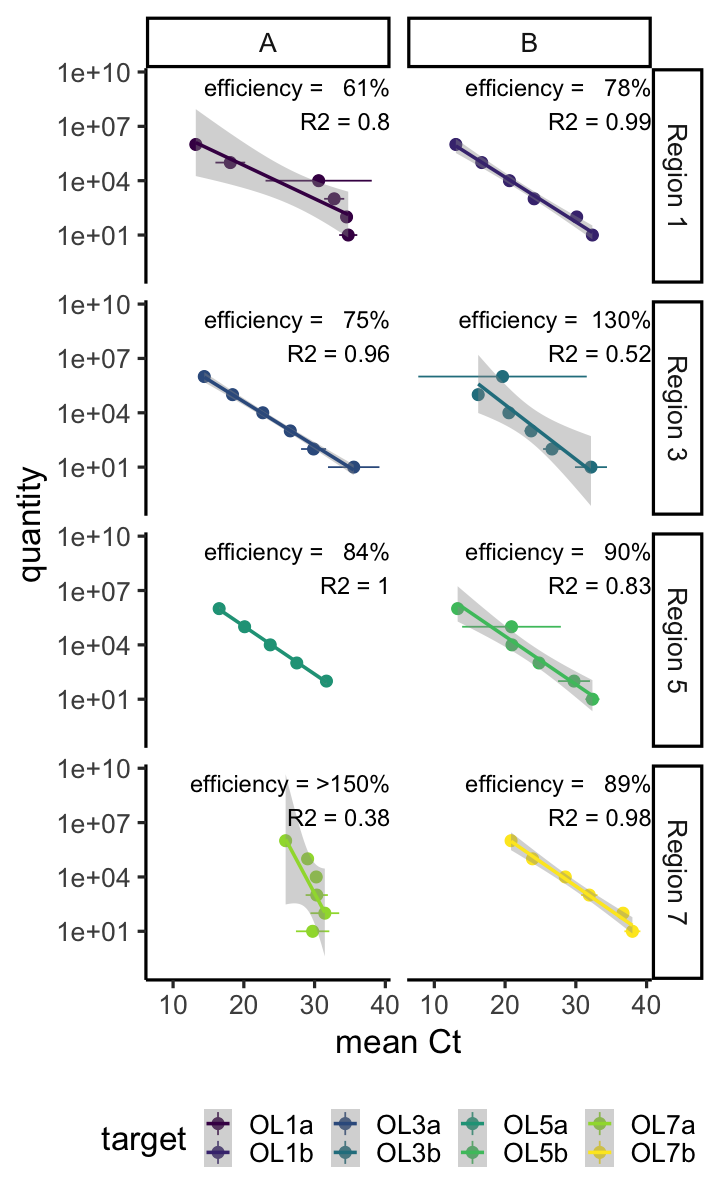

In [10]:
options(repr.plot.width =6, repr.plot.height = 10) #change the size of the plot
theme_set(theme_classic(base_size=20))# set font size

a<-assay_dev_OL_subbed_tog

g<- ggplot(a, aes(x=CT_mean, y=quantity))+
    geom_pointrange(aes(x=CT_mean, y=quantity, xmin= CT_mean -CT_std, xmax= CT_mean +CT_std, color=target ))+
    geom_point(size=3, aes(color=target))+
    geom_smooth(method='lm', aes(color=target))+
    xlab("mean Ct")+
    scale_color_viridis_d()+
    facet_grid(target_region~ assay_letter)+
    scale_y_log10()+
    theme(legend.position= "bottom")

dfl<-std_curves_dev_OL
dfl$efficiency_sub<- format(dfl$efficiency, digits=0)
dfl[dfl$efficiency > 150, "efficiency_sub"]<-">150"
dfl[grepl("a", dfl$target), "assay_letter"]<-"A"
dfl[grepl("b", dfl$target), "assay_letter"]<-"B"

dfl<- dfl%>% 
mutate(Label=paste("efficiency = ",efficiency_sub,"%\nR2 = ",r_sq, sep=""))

g + geom_text(data=dfl,aes(x=+Inf,y=+Inf,label=Label),
hjust = 1,vjust=1.2, size=5)

ggsave(paste0(path_f,"Figure_S6.jpg"),  units='mm',device= 'jpg',width=max_w*(4/5), height=max_h)


## 4. qPCR 

In [11]:
# Lower detection limits
qpcr_ORF_lower_collab<- 5 #gc/rxn  
qpcr_SYBR_lower_collab<-10
qpcr_SYBR_lower_MK<-40


#make dataframes with LODs by assay
assay_exp1234<-c("ORF", "ORF_exp2", "MK1","MK3","MK5","MK7","MK1_exp2","MK3_exp2","MK5_exp2","MK7_exp2","OL1b", "OL3a","OL5a","OL7b")

low_gcrxn_exp1234<- c(qpcr_ORF_lower_collab,qpcr_ORF_lower_collab, qpcr_SYBR_lower_MK,qpcr_SYBR_lower_MK, qpcr_SYBR_lower_MK,qpcr_SYBR_lower_MK,qpcr_SYBR_lower_MK,qpcr_SYBR_lower_MK, qpcr_SYBR_lower_MK,qpcr_SYBR_lower_MK,qpcr_SYBR_lower_collab,qpcr_SYBR_lower_collab,100,1000)

temp_vol_exp1234<-c(5,5, 2,2,2,2, 2,2,2,2,2,2,2,2)

lod_exp1234<-data.frame(assay_exp1234,low_gcrxn_exp1234,temp_vol_exp1234)
names(lod_exp1234)<-c("target","low_gc.rxn","template_volume_ul")
lod_exp1234$elution_volume_ul<-60
lod_exp1234$extracted_volume_ul<-200
lod_exp1234$dim_conv<- (lod_exp1234$elution_volume_ul * 1000)/(lod_exp1234$extracted_volume_ul *lod_exp1234$template_volume_ul)
lod_exp1234$low_gc.ml<-lod_exp1234$low_gc.rxn  * lod_exp1234$dim_conv

### Individual Standard Curves

In [12]:
# subset based on LoD
expt_1234_std<-left_join(expt_1234_std,lod_exp1234[,c("target","low_gc.rxn")])
expt_1234_std<-expt_1234_std[(as.numeric(expt_1234_std$quantity) >= expt_1234_std$low_gc.rxn),]
expt_1234_std<-expt_1234_std[,c("quantity","CT","plate_id","target")]
std_curves_1234<- std_assess(expt_1234_std)

std_curves_ORF<-rbind(std_curves_1234[std_curves_1234$target=="ORF",])
std_curves_SYBR<-rbind(std_curves_1234[std_curves_1234$target!="ORF",],std_curves_dev_OL_long[std_curves_dev_OL_long$target %in% assay_exp1234,],std_curves_dev_MK_long[std_curves_dev_MK_long$target %in% assay_exp1234,])

std_curves_ORF
expt_1234<-expt_1234_std

expt_1234_std<-left_join(expt_1234_std,std_curves_1234)

Joining, by = "target"


,plate_id,intercept,slope,r_sq,num_pts,efficiency,max_ct,target
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2,P1000,36.77622,-3.765007,0.99,7.5,84.33,32.99,ORF
3,P1005,37.78538,-3.986454,1.00,7.5,78.18,32.90,ORF
4,P81,36.05405,-3.430936,1.00,7.0,95.64,34.91,ORF
5,P82,35.76019,-3.395174,1.00,7.0,97.03,33.43,ORF
6,P83,35.74415,-3.435462,1.00,7.0,95.47,34.08,ORF
7,P89,37.96381,-3.688407,1.00,7.0,86.69,35.24,ORF


Joining, by = c("plate_id", "target")


[1] "ORF dsDNA" "ORF ssRNA" "MK3"       "MK1"       "MK5"       "MK7"      
 [7] "OL1b"      "OL3a"      "OL5a"      "OL7b"

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



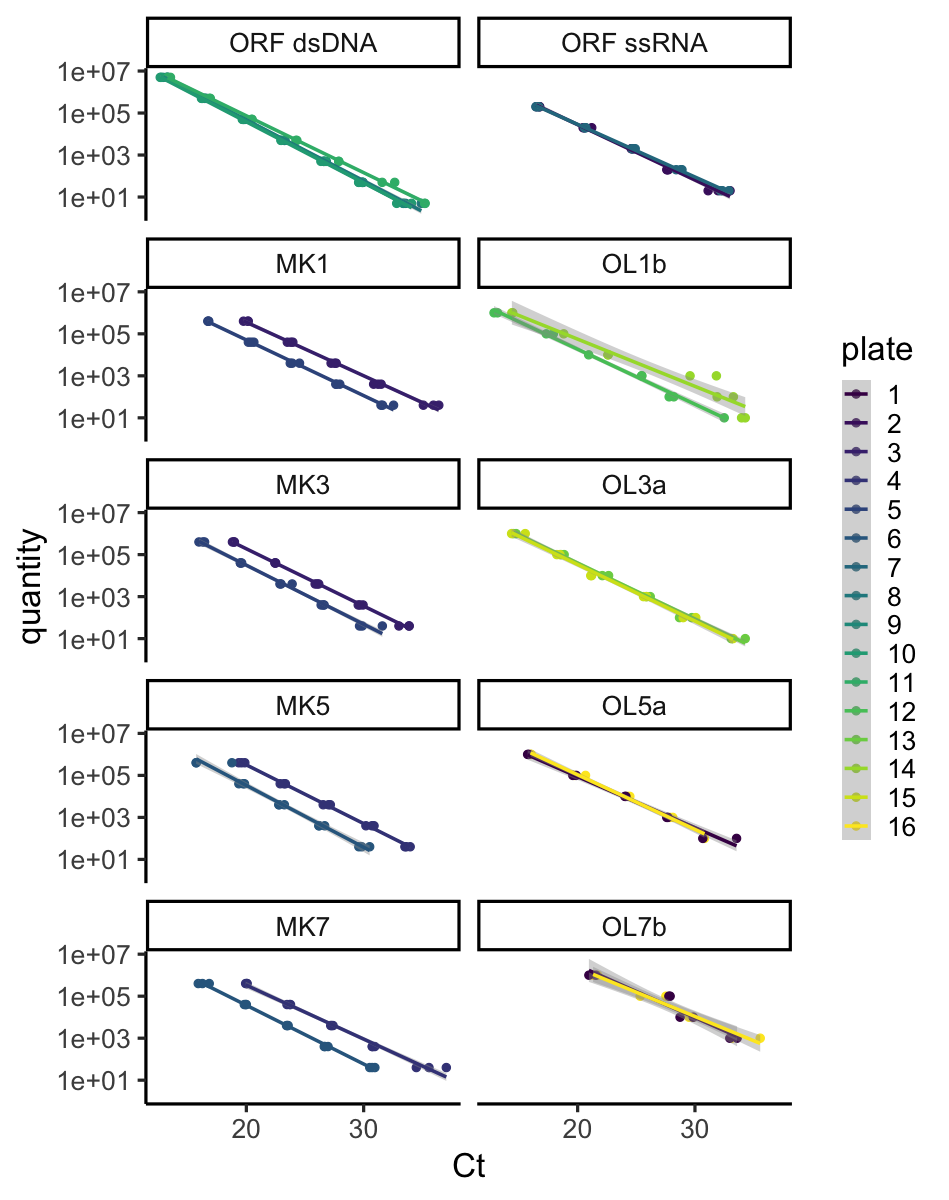

In [13]:
b=10
options(repr.plot.width =b*(max_w/max_h), repr.plot.height = b) #change the size of the plot
theme_set(theme_classic(base_size=20))# set font size

c<-expt_1234

c$CT<- as.numeric(c$CT)
c[(c$plate_id %in% c("P1000","P1005"))&(c$target=="ORF"),"target"]<-"ORF ssRNA"
c[(!(c$plate_id %in% c("P1000","P1005")))&(c$target=="ORF"),"target"]<-"ORF dsDNA"
c$plate_id<- as.factor(c$plate_id)
levels(c$plate_id)<- as.character(1:length(unique(c$plate_id)))
unique(c$target)
c$target<-factor(c$target, levels=c("ORF dsDNA", "ORF ssRNA", "MK1","OL1b","MK3","OL3a","MK5","OL5a","MK7","OL7b"))

g<- ggplot(c, aes(x=CT, y=quantity))+
    geom_point(size=2, aes(color=plate_id))+
    geom_smooth(method='lm', aes(color=plate_id))+
    xlab("Ct")+
    scale_color_viridis_d()+
    facet_wrap(~target, ncol=2)+
    labs(color="plate")+
    scale_y_log10()+
    theme(legend.position= "right")

g


ggsave(paste0(path_f,"Figure_S7.jpg"),  units='mm',device= 'jpg',width=max_w, height=max_h)


### Master Standard Curves

In [14]:
#  master curves
#add in curves from development
cols<- names(expt_1234)
OLp<-assay_development_OL[assay_development_OL$target %in% assay_exp1234,cols]
MKp<-assay_development_MK[assay_development_MK$target %in% assay_exp1234,cols]
dev<- rbind(OLp,MKp)
dev<-left_join(dev,lod_exp1234[,c("target","low_gc.rxn")])
dev<-dev[(as.numeric(dev$quantity) >= dev$low_gc.rxn),]
dev<-dev[,c("quantity","CT","plate_id","target")]

std_df_master<- rbind(expt_1234,dev)

exp2_s<-c("P1003","P1004","P1005")
std_df_master[std_df_master$plate_id %in% exp2_s,"target"] <- paste0(std_df_master[std_df_master$plate_id %in% exp2_s,"target"],"_exp2")

std_df_master[(std_df_master$plate_id %in% c("P1000","P1005"))&(std_df_master$target=="ORF"),"target"]<-"ORF-RNAstd"

std_df_master_curves<-std_assess_master(std_df_master) #max_ct is the max of a single replicate from all replicates in master curves
# std_df_master_curves

#format for paper
c<-std_df_master_curves

c[(c$target=="ORF-RNAstd"),"target"]<-"ORF\nssRNA"
c[(c$target=="ORF"),"target"]<-"ORF\ndsDNA"
c[(c$target=="ORF_exp2"),"target"]<-"ORF\nssRNA_exp2"
c<-c[,c("target","r_sq","efficiency","slope","intercept")]
names(c)<-  c("target","R2","efficiency","slope","intercept")
c$target<-factor(c$target, levels=c("ORF\nssRNA","ORF\ndsDNA","ORF\nssRNA_exp2",'MK1','MK3','MK5','MK7','MK1_exp2','MK3_exp2','MK5_exp2','MK7_exp2','OL1b','OL3a','OL5a','OL7b'))
c<-c[order(c$target),]

Joining, by = "target"


In [15]:
stargazer(c,type="html", summary=FALSE, rownames=FALSE, digits=2, out=paste0(path_f,"Table_S7.doc"))


<table style="text-align:center"><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">target</td><td>R2</td><td>efficiency</td><td>slope</td><td>intercept</td></tr>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">ssRNA</td><td>0.99</td><td>84.33</td><td>-3.77</td><td>36.78</td></tr>
<tr><td style="text-align:left">dsDNA</td><td>0.99</td><td>93.53</td><td>-3.49</td><td>36.38</td></tr>
<tr><td style="text-align:left">ssRNA_exp2</td><td>1</td><td>78.18</td><td>-3.99</td><td>37.79</td></tr>
<tr><td style="text-align:left">MK1</td><td>0.99</td><td>83.48</td><td>-3.79</td><td>40.91</td></tr>
<tr><td style="text-align:left">MK3</td><td>0.99</td><td>86.93</td><td>-3.68</td><td>39.15</td></tr>
<tr><td style="text-align:left">MK5</td><td>0.98</td><td>87.23</td><td>-3.67</td><td>39.47</td></tr>
<tr><td style="text-align:left">MK7</td><td>0.99</td><td>84.74</td><td>-3.75</td><td>40.79</td></tr>
<t

### Convert from CT to quantity

In [16]:
#bind
expt_1234_unk_ntc[expt_1234_unk_ntc$plate_id %in% exp2_s,"target"] <- paste0(expt_1234_unk_ntc[expt_1234_unk_ntc$plate_id %in% exp2_s,"target"],"_exp2")
expt_1234_unk_ntc_std<- left_join(expt_1234_unk_ntc,std_df_master_curves)

#sub in a value for undetermined samples
expt_1234_unk_ntc_std$temp_lab <- "N"
expt_1234_unk_ntc_std[expt_1234_unk_ntc_std$CT =="Undetermined","temp_lab"]<- "Y"
expt_1234_unk_ntc_std$CT<-as.character(expt_1234_unk_ntc_std$CT)
expt_1234_unk_ntc_std[expt_1234_unk_ntc_std$CT =="Undetermined","CT"]<- "60"
expt_1234_unk_ntc_std$CT<-as.numeric(expt_1234_unk_ntc_std$CT)

expt_1234_unk_ntc_std[,"quantity"]<-10^(((expt_1234_unk_ntc_std[,"CT"])-(expt_1234_unk_ntc_std[,"intercept"]))/expt_1234_unk_ntc_std[,"slope"])
expt_1234_unk_ntc_std$CT<-as.character(expt_1234_unk_ntc_std$CT)
expt_1234_unk_ntc_std[expt_1234_unk_ntc_std$temp_lab =="Y","CT"]<-"Undetermined"
head(expt_1234_unk_ntc_std)

dfq_unk_expc<-expt_1234_unk_ntc_std #give it a shorter name

Joining, by = "target"


,sample_id,id,storage_condition,reactor,filtered,RNase_treated,time_point,dilution_factor,target,task,⋯,experiment,experiment_manuscript_label,intercept,slope,r_sq,num_pts,efficiency,max_ct,temp_lab,quantity
,<chr>,<chr>,<int>,<chr>,<lgl>,<chr>,<chr>,<int>,<chr>,<chr>,⋯,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,extraction_intpos_Matrix-N-C8-1x,extraction_intposOL_Matrix,NA,NA,NA,N,C8,1,ORF,UNKNOWN,⋯,extraction_control_1234,control,36.38055,-3.487495,0.99,28,93.53,35.24,N,3010.470
2,extraction_intpos_Matrix-Y-C8-1x,extraction_intposOL_Matrix,NA,NA,NA,Y,C8,1,ORF,UNKNOWN,⋯,extraction_control_1234,control,36.38055,-3.487495,0.99,28,93.53,35.24,N,2415.962
3,20A1F-N-T0-1x,20A1F,20,A1,FALSE,N,T0,1,ORF,UNKNOWN,⋯,3,20-1,36.38055,-3.487495,0.99,28,93.53,35.24,N,7840.165
4,20A1F-N-T0-1x,20A1F,20,A1,FALSE,N,T0,1,ORF,UNKNOWN,⋯,3,20-1,36.38055,-3.487495,0.99,28,93.53,35.24,N,8252.104
5,20A1F-N-T0-5x,20A1F,20,A1,FALSE,N,T0,5,ORF,UNKNOWN,⋯,3,20-1,36.38055,-3.487495,0.99,28,93.53,35.24,N,2040.985
6,20A1F-N-T0-5x,20A1F,20,A1,FALSE,N,T0,5,ORF,UNKNOWN,⋯,3,20-1,36.38055,-3.487495,0.99,28,93.53,35.24,N,1999.438


### Calculate mean of technical replicates

In [17]:
#add id for controls
dfq_unk_expc[dfq_unk_expc$task=="NTC", "sample_id"]<- "NTC"
dfq_unk_expc[dfq_unk_expc$task=="NTC", "id"]<- "NTC"

controls<-c("extraction_intposOL_Matrix","extraction_RNAposOL_Matrix","extraction_neg", "extraction_intpos", "extraction_RNApos","extraction_intpos_Matrix","NTC")
dfq_unk_expc$dilution_factor<-as.numeric(dfq_unk_expc$dilution_factor)
dfq_unk_expc[(dfq_unk_expc$id %in% controls) &is.na(dfq_unk_expc$dilution_factor), "dilution_factor"]<- 1 

dfq_unk_expc[is.na(dfq_unk_expc$experiment), "experiment"]<-"control"
sub2<-dfq_unk_expc[dfq_unk_expc$experiment %in% c("1","2","3","4","control_3","control_4","extraction_control_1234"),]
sub2<-left_join(sub2, lod_exp1234)
dfq_unk_exp_lod<-sub2

dfq_unk_exp_lod[,"max_ct"]<-(log10(dfq_unk_exp_lod[,"low_gc.rxn"])*dfq_unk_exp_lod[,"slope"])+ dfq_unk_exp_lod[,"intercept"]#current max_ct is the max of all replicates and doesn't represent bottom of std curve

#sub in for undetermined or bdl (for now 1/2 LoD)
dfq_unk_exp_lod$quantity_sub<- dfq_unk_exp_lod$quantity
dfq_unk_exp_lod[(dfq_unk_exp_lod$quantity < dfq_unk_exp_lod$low_gc.rxn),"quantity_sub" ] <- dfq_unk_exp_lod[(dfq_unk_exp_lod$quantity < dfq_unk_exp_lod$low_gc.rxn),"low_gc.rxn" ]/2

#sub in max CT for any undetermineds -- inhibition test only
dfq_unk_exp_lod[dfq_unk_exp_lod$CT=="Undetermined", "CT"]<- dfq_unk_exp_lod[dfq_unk_exp_lod$CT=="Undetermined", "max_ct"]
dfq_unk_exp_lod$CT <- as.numeric(dfq_unk_exp_lod$CT)

#calculate the technical average
dfq_unk_exp_lod_tech<- dfq_unk_exp_lod %>%
  group_by(id, time_point, target, template_volume_ul, dilution_factor, RNase_treated,storage_condition,plate_id, elution_volume_ul, extracted_volume_ul, low_gc.rxn, dim_conv,low_gc.ml, experiment,max_ct) %>%
  summarize(num_qpcr_techreps= as.numeric(n()),
            mean_quantity = as.numeric(mean(quantity_sub, na.rm = TRUE)),
            mean_CT = as.numeric(mean(CT, na.rm = TRUE)),
            tech_std = as.numeric(sd(quantity_sub, na.rm = TRUE)))

# dfq_unk_exp_lod_tech[(dfq_unk_exp_lod_tech$num_qpcr_techreps>2)&(dfq_unk_exp_lod_tech$id!="NTC"),] #0 samples
# dfq_unk_exp_lod_tech[dfq_unk_exp_lod_tech$num_qpcr_techreps<2,] #8 all are controls that were rerun on a later plate
dfq_unk_exp_lod_tech<-dfq_unk_exp_lod_tech[dfq_unk_exp_lod_tech$num_qpcr_techreps>1,] #this filters the above out
dfq_unk_exp_lod_tech$target<- gsub("_exp2","",dfq_unk_exp_lod_tech$target)

Joining, by = "target"
`summarise()` has grouped output by 'id', 'time_point', 'target',
'template_volume_ul', 'dilution_factor', 'RNase_treated', 'storage_condition',
'plate_id', 'elution_volume_ul', 'extracted_volume_ul', 'low_gc.rxn',
'dim_conv', 'low_gc.ml', 'experiment'. You can override using the `.groups`
argument.


### Inhibition

In [18]:
#check for inhibition
dfq_unk_exp_lod_tech$CT_buffer<-NA #Cao et al. 2012 
dfq_unk_exp_lod_tech[dfq_unk_exp_lod_tech$dilution_factor==1,"CT_buffer"] <- 2.32 + 1 #2.32 cycles per 5x dilution +1 buffer
dfq_unk_exp_lod_tech[dfq_unk_exp_lod_tech$dilution_factor==5,"CT_buffer"] <- 0 #1.32 cycles per 5/2x dilution +1 buffer

dfq_unk_exp_lod_tech$inhib_check<-dfq_unk_exp_lod_tech$mean_CT - dfq_unk_exp_lod_tech$CT_buffer

dfq_unk_exp_lod_tech_f<- dfq_unk_exp_lod_tech %>%
  group_by(id, time_point, target, experiment, RNase_treated,low_gc.ml, max_ct) %>% mutate(n = n() ) 

dfq_unk_exp_lod_tech_f<- dfq_unk_exp_lod_tech_f %>%
  group_by(id, time_point, target, experiment, RNase_treated,low_gc.ml,n,max_ct)%>%  mutate(both_equal_check = mean(mean_CT) ) 

dfq_unk_exp_lod_tech_f<- dfq_unk_exp_lod_tech_f %>%
  group_by(id, time_point, target, experiment, RNase_treated,low_gc.ml,n,max_ct)%>%  filter(inhib_check == min(inhib_check))

dfq_unk_exp_lod_tech_f$inhibited<-"Unk"
dfq_unk_exp_lod_tech_f[(dfq_unk_exp_lod_tech_f$n>1)&(as.numeric(dfq_unk_exp_lod_tech_f$dilution_factor) > 2), "inhibited"]<- "Y"
dfq_unk_exp_lod_tech_f[(dfq_unk_exp_lod_tech_f$n>1)&(as.numeric(dfq_unk_exp_lod_tech_f$dilution_factor) <= 2), "inhibited"]<- "N"
dfq_unk_exp_lod_tech_f[(dfq_unk_exp_lod_tech_f$id %in% controls), "inhibited"]<- "Unk" #dont test controls for inhibition because compares NTCs and inflates totals
dfq_unk_exp_lod_tech_f[dfq_unk_exp_lod_tech_f$both_equal_check == dfq_unk_exp_lod_tech_f$mean_CT, "inhibited"]<- "Unk" #mostly BDL values or randomly chose 1 or 5 bc the values were the same

qpcr_fin_expc<-dfq_unk_exp_lod_tech_f[,c('time_point','id','target',"RNase_treated","inhibited","storage_condition","low_gc.ml","max_ct","mean_quantity","elution_volume_ul","extracted_volume_ul","template_volume_ul","dilution_factor","low_gc.rxn","experiment","tech_std")]

In [19]:
# qpcr_fin_expc
inhib<-qpcr_fin_expc #starting from 259
inhib<-inhib[(inhib$inhibited!="Unk"),] #109 were Unk because they were from experiments 1 & 2, controls or ran out of sample for 1x or diluted out the 5x

inhib$count<-NA
inhib[inhib$inhibited =="Y", "count"]<- 1
inhib[inhib$inhibited =="N", "count"]<- 0

inhib_tot<-inhib%>%group_by(target)%>%summarize(total=n(), inhibited= sum(count))
inhib_tot$Percent_inhibited<- (inhib_tot$inhibited/inhib_tot$total) *100
inhib_tot

target,total,inhibited,Percent_inhibited
<chr>,<int>,<dbl>,<dbl>
OL1b,30,0,0
OL3a,30,0,0
OL5a,30,0,0
OL7b,30,0,0
ORF,30,0,0


### Dimensional analysis

In [20]:
# sub in 1x for samples at LoD
qpcr_fin_expc[(qpcr_fin_expc$mean_quantity< qpcr_fin_expc$low_gc.rxn), "dilution_factor"] <- 1

#dimensional analysis/conversion
unique(qpcr_fin_expc$target) 
qpcr_fin_expc$conc_gc_per_mL<-NA
qpcr_fin_expc$conc_gc_per_mL<- qpcr_fin_expc$mean_quantity * (qpcr_fin_expc$elution_volume_ul*1000)/(qpcr_fin_expc$extracted_volume_ul* qpcr_fin_expc$template_volume_ul) * qpcr_fin_expc$dilution_factor
qpcr_fin_expc$tech_std_gc_per_mL<- qpcr_fin_expc$tech_std * (qpcr_fin_expc$elution_volume_ul*1000)/(qpcr_fin_expc$extracted_volume_ul* qpcr_fin_expc$template_volume_ul) * qpcr_fin_expc$dilution_factor
head(qpcr_fin_expc)

assign_expt<-unique(qpcr_fin_expc[,c("id","experiment")]) #for merge

[1] "MK1"  "MK3"  "MK5"  "MK7"  "ORF"  "OL1b" "OL3a" "OL5a" "OL7b"

time_point,id,target,RNase_treated,inhibited,storage_condition,low_gc.ml,max_ct,mean_quantity,elution_volume_ul,extracted_volume_ul,template_volume_ul,dilution_factor,low_gc.rxn,experiment,tech_std,conc_gc_per_mL,tech_std_gc_per_mL
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
T0,15A5F,MK1,N,Unk,15,6000,34.83609,230.6877,60,200,2,1,40,1,49.141587,34603.15,7371.2380
T0,15A5F,MK3,N,Unk,15,6000,33.25661,1025.0600,60,200,2,1,40,1,78.517029,153759.00,11777.5543
T0,15A5F,MK5,N,Unk,15,6000,33.58420,681.9786,60,200,2,1,40,1,5.480359,102296.79,822.0539
T0,15A5F,MK7,N,Unk,15,6000,34.78055,2219.8126,60,200,2,1,40,1,43.706565,332971.89,6555.9847
T0,15A5F,ORF,N,Unk,15,300,33.94290,8034.5200,60,200,5,1,5,1,406.210131,482071.20,24372.6078
T1,15A5F,MK1,N,Unk,15,6000,34.83609,221.1400,60,200,2,1,40,1,37.788668,33171.01,5668.3002


### Check extraction and qPCR Controls

#### NTCs

In [21]:
#quality check for NTCs & controls then filter out controls
ntc<-dfq_unk_expc[(dfq_unk_expc$id=="NTC"),]
ntc_amp<-ntc[ntc$CT!='Undetermined',]# 11 out of 58 amplified
ntc_amp_inside_curve<-ntc_amp[(ntc_amp$CT < ntc_amp$max_ct),c("CT","max_ct", "target","plate_id")] #  3/11 amplified within the standard curve
ps<-dfq_unk_exp_lod[(dfq_unk_exp_lod$plate_id%in%c("P91","P92"))&(dfq_unk_exp_lod$task =="UNKNOWN"),] 
ps<-ps %>% group_by(plate_id)  %>% summarize(max_sample_ct = max(CT))
ntc_amp_inside_curve<-left_join(ntc_amp_inside_curve,ps)
ntc_amp_inside_curve
ntc_amp_inside_curve[(ntc_amp_inside_curve$CT < ntc_amp_inside_curve$max_sample_ct),] #3/3 were >5 CT  higher than the highest sample on the plate

Joining, by = "plate_id"


CT,max_ct,target,plate_id,max_sample_ct
<chr>,<dbl>,<chr>,<chr>,<dbl>
33.97143,34.29,OL1b,P91,28.72668
38.89718,39.53,OL3a,P92,29.53575
32.77946,39.53,OL3a,P92,29.53575


CT,max_ct,target,plate_id,max_sample_ct
<chr>,<dbl>,<chr>,<chr>,<dbl>


#### negative extraction and experimental controls

In [22]:
print('should say TRUE 2x') #all conditions set up such that if the control is working the return is TRUE
#check other controls
dfq_control<- qpcr_fin_expc %>% filter(str_detect(id, "extraction_intposOL_Matrix|extraction_RNAposOL_Matrix|extraction_intpos_Matrix|extraction_intpos|extraction_neg|extraction_RNApos|NTC"))
intp_noro<-dfq_control[(dfq_control$id %in% c("extraction_intposOL_Matrix","extraction_intposMK_Matrix")),] #experiments 3 & 4 ORF only

#check extraction negs
unique(unlist(dfq_control[((dfq_control$id=="extraction_neg")),"conc_gc_per_mL"]<dfq_control[((dfq_control$id=="extraction_neg")),"low_gc.ml"])) 

#Check extraction_RNApos
rnap_noro<-dfq_control[(dfq_control$id %in% c("extraction_RNAposOL","extraction_RNAposOL_Matrix")),] #experiments 3 & 4 ORF only
unique(unlist(rnap_noro[(rnap_noro$RNase_treated=="Y"),"conc_gc_per_mL" ] <rnap_noro[(rnap_noro$RNase_treated=="Y"),"low_gc.ml"])) #includes ORF only
rnap_noro<-rnap_noro[(rnap_noro$RNase_treated=="N"),]

[1] "should say TRUE 2x"


conc_gc_per_mL
TRUE


conc_gc_per_mL
TRUE


#### Check positive extraction controls

In [23]:
intp_noro_y<-intp_noro[(intp_noro$RNase_treated=="Y"),]
intp_noro_n<-intp_noro[(intp_noro$RNase_treated=="N"),]
format(mean(intp_noro_y$conc_gc_per_mL), scientific = TRUE, digits=2)
format(sd(intp_noro_y$conc_gc_per_mL), scientific = TRUE, digits=2)
format(mean(intp_noro_n$conc_gc_per_mL), scientific = TRUE, digits=2)
format(sd(intp_noro_n$conc_gc_per_mL), scientific = TRUE, digits=2)

format(mean(rnap_noro$conc_gc_per_mL), scientific = TRUE, digits=2)
format(sd(rnap_noro$conc_gc_per_mL), scientific = TRUE, digits=2)
# rnap_noro


[1] "1.1e+05"

[1] "4.3e+04"

[1] "1.5e+05"

[1] "5e+04"

[1] "1.3e+03"

[1] "6.2e+02"

#### Remove controls from the main dataset

In [24]:
# remove controls from main dataset
qpcr_fin_expc<- qpcr_fin_expc %>% filter(!str_detect(id, "extraction_intposOL_Matrix|extraction_RNAposOL_Matrix|extraction_intpos_Matrix|extraction_intpos|extraction_neg|extraction_RNApos|NTC"))
qpcr_fin<-qpcr_fin_expc[,c('time_point','id','target','conc_gc_per_mL',"RNase_treated","storage_condition","low_gc.ml","tech_std_gc_per_mL")]

## 5. HIE assay

### HuNoV Calculate mean of technical and experimental replicates

In [25]:
collab_derep<- hunov %>%
  group_by(id, time_point, target, storage_condition) %>%
  summarize(mean_conc_gc_per_mL = as.numeric(mean(conc_gc_per_mL, na.rm = TRUE)),
            tech_std_gc_per_mL = as.numeric(sd(conc_gc_per_mL, na.rm = TRUE)))
collab_culture<-collab_derep
collab_culture$low_conc<- ((1340*2)/100)*1000 
collab_culture$conc_units<-"gc.ml"
collab_culture$RNase_treated<-"N"

head(collab_culture)

`summarise()` has grouped output by 'id', 'time_point', 'target'. You can
override using the `.groups` argument.


id,time_point,target,storage_condition,mean_conc_gc_per_mL,tech_std_gc_per_mL,low_conc,conc_units,RNase_treated
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
15A5F,T0,HuNoV_culture,15,419534.47,266527.95,26800,gc.ml,N
15A5F,T1,HuNoV_culture,15,47226.15,14586.74,26800,gc.ml,N
15A5F,T14,HuNoV_culture,15,13400.00,0.00,26800,gc.ml,N
15A5F,T21,HuNoV_culture,15,13400.00,0.00,26800,gc.ml,N
15A5F,T28,HuNoV_culture,15,13400.00,0.00,26800,gc.ml,N
15A5F,T7,HuNoV_culture,15,13400.00,0.00,26800,gc.ml,N


## 6. Merge qPCR and culture results

In [26]:
names(qpcr_fin)[names(qpcr_fin) == 'conc_gc_per_mL'] <- 'conc'
names(qpcr_fin)[names(qpcr_fin) == 'low_gc.ml'] <- 'low_conc'
qpcr_fin$conc_units<-'gc.ml'
names(collab_culture)[names(collab_culture) == 'mean_conc_gc_per_mL'] <- 'conc'

df<-rbind(qpcr_fin, collab_culture)
df<-left_join(df, assign_expt)
df$day<-as.numeric(gsub("T","",as.character(df$time_point)))

#parse out R1 & R2 (and temp and U/F and R) and add error bars based on R1 & R2 experimental reps
par<- c('15C1N', '15C2P','15R1F','15R2F','15R1U','15R2U', '10R1F','10R2F', '10R1U','10R2U','20R1F','20R2F', '20R1U','20R2U',"20A1F", "20A2F", "20A3F", "20A4F","20C5N","20C6P", "20C3P", "20C4P","15A5F","15A6F")
df_npar<- df[!(df$id %in% par), ]
df_par<- df[df$id %in% par, ]
df_par<-df_par[,c('experiment','time_point','id','conc','tech_std_gc_per_mL', 'RNase_treated','day','target','low_conc','conc_units')]
df_par<- df_par%>% 
    separate(id, c('storage_condition', 'reactor', 'filtered'), sep = c(2,4), remove = FALSE) 
df_par$storage_condition<- as.numeric(df_par$storage_condition)
df_npar$filtered<- NA
df_npar$reactor<- NA
df_npar$reactor<- as.character(df_npar$reactor)
df_npar$filtered<- as.character(df_npar$filtered)
df<-rbind(df_par,df_npar)
head(df)

export<- df[,c("id","storage_condition","RNase_treated","day","target","conc","tech_std_gc_per_mL","conc_units")]
names(export)<- c("reactor_id","storage_condition","RNase_treated","day","target","concentration_technical_average", "concentration_technical_standard_deviation","concentration_units")
export$experiment_manuscript_label<- NA
export[export$reactor_id == "15A5F", "experiment_manuscript_label"]<- "15-1"
export[export$reactor_id == "15A6F", "experiment_manuscript_label"]<- "15-2"
export[export$reactor_id %in% c("20A1F","20A2F"), "experiment_manuscript_label"]<- "20-1"
export[export$reactor_id %in% c("20A3F","20A4F"), "experiment_manuscript_label"]<- "20-2"
write.csv(export,"hunov_qpcr_gcperml.csv", row.names = FALSE)

Joining, by = "id"


experiment,time_point,id,storage_condition,reactor,filtered,conc,tech_std_gc_per_mL,RNase_treated,day,target,low_conc,conc_units
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>
1,T0,15A5F,15,A5,F,34603.15,7371.2380,N,0,MK1,6000,gc.ml
1,T0,15A5F,15,A5,F,153759.00,11777.5543,N,0,MK3,6000,gc.ml
1,T0,15A5F,15,A5,F,102296.79,822.0539,N,0,MK5,6000,gc.ml
1,T0,15A5F,15,A5,F,332971.89,6555.9847,N,0,MK7,6000,gc.ml
1,T0,15A5F,15,A5,F,482071.20,24372.6078,N,0,ORF,300,gc.ml
1,T1,15A5F,15,A5,F,33171.01,5668.3002,N,1,MK1,6000,gc.ml


In [27]:
df_group<- df
df_group$value<-df_group$conc
df_group$targ_RNase<- paste0(df_group$target, df_group$RNase_treated,df_group$id)

targs<- unique(df_group$targ_RNase)
t0_df<- data.frame()

for(targ in targs){
    t0_df_t<-df_group[(df_group$targ_RNase==targ)&(df_group$time_point=="T0"),]
    t0_df_t$t0<- t0_df_t$conc
    t0_df_t$t0_tech_std<- t0_df_t$tech_std_gc_per_mL
    t0_df_t=t0_df_t[,c("id","filtered", "storage_condition","RNase_treated","target","t0","t0_tech_std")]
    t0_df= rbind(t0_df, t0_df_t)}

df_group<-left_join(df_group,t0_df)

df_group$lnNN0<-log(as.numeric(df_group$value)/as.numeric(df_group$t0))

#regions
df_group$target_region<- df_group$target
df_group[df_group$target %in% c("OL1b","MK1"), "target_region"]<- "1"
df_group[df_group$target %in% c("OL3a","MK3"), "target_region"]<- "3"
df_group[df_group$target %in% c("OL5a","MK5"), "target_region"]<- "5"
df_group[df_group$target %in% c("OL7b","MK7"), "target_region"]<- "7"

df_ungroup<-df_group

df_ungroup$NN0<-as.numeric(df_ungroup$value)/as.numeric(df_ungroup$t0)
df_ungroup$lnNN0<-log(df_ungroup$NN0)
df_ungroup$bdl<- "quantifiable"
df_ungroup[df_ungroup$conc < df_ungroup$low_conc,"bdl"]<-"not quantifiable"

df_ungroup$std_lnNN0<- sqrt((df_ungroup$tech_std_gc_per_mL/df_ungroup$value)^2 + ((df_ungroup$t0_tech_std/df_ungroup$t0))^2)
df_ungroup$lower_limit_log<-log(df_ungroup$low_conc/df_ungroup$t0)
df_ungroup$type<- paste(df_ungroup$reactor,df_ungroup$experiment,df_ungroup$storage_condition,df_ungroup$RNase_treated,df_ungroup$filtered,df_ungroup$target,df_ungroup$target_region,sep="-")
head(df_ungroup)

# make grouped to see the error bars between ks (if one is ND and one is detected, it takes the average of the subbed 1/2lower limit value and detected value)
df_group_t0<- df_group %>%
  group_by(storage_condition, filtered, experiment, RNase_treated,target,target_region) %>%
  summarize( mean_t0 = as.numeric(mean(t0, na.rm = TRUE)),
           std_t0= as.numeric(sd(t0, na.rm = TRUE)))

df_group<- df_group %>%
  group_by(storage_condition, filtered, RNase_treated,experiment, time_point, day, target,target_region,low_conc) %>%
  summarize(num_expreps= as.numeric(n()),
           mean_value = as.numeric(mean(value, na.rm = TRUE)),
            conc = as.numeric(mean(conc, na.rm = TRUE)),
           std_value= as.numeric(sd(value, na.rm = TRUE)))
df_group<-left_join(df_group, df_group_t0)  

df_group$mean_NN0<-as.numeric(df_group$mean_value)/as.numeric(df_group$mean_t0)
df_group$mean_lnNN0<-log(df_group$mean_NN0)
df_group$bdl<- "quantifiable"
df_group[df_group$conc < df_group$low_conc,"bdl"]<-"not quantifiable"


df_group[is.na(df_group$std_value), "std_value"]<- 0 #This is for plotting purposes includes all time series with only 1 experimental replicate 
df_group$std_lnNN0<- sqrt((df_group$std_value/df_group$mean_value)^2 + ((df_group$std_t0/df_group$mean_t0))^2)
df_group$lower_limit_log<-log(df_group$low_conc/df_group$mean_t0)
df_group$type<- paste(df_group$experiment,df_group$storage_condition,df_group$RNase_treated,df_group$filtered,df_group$target,df_group$target_region,sep="-")
head(df_group)

df_ungroup[df_ungroup$target=="HuNoV_culture", "target"]<-"HIE Assay"
df_ungroup[df_ungroup$target_region=="HuNoV_culture", "target_region"]<-"HIE Assay"

df_group[df_group$target=="HuNoV_culture", "target"]<-"HIE Assay"
df_group[df_group$target_region=="HuNoV_culture", "target_region"]<-"HIE Assay"

Joining, by = c("id", "storage_condition", "filtered", "RNase_treated",
"target")


experiment,time_point,id,storage_condition,reactor,filtered,conc,tech_std_gc_per_mL,RNase_treated,day,⋯,targ_RNase,t0,t0_tech_std,lnNN0,target_region,NN0,bdl,std_lnNN0,lower_limit_log,type
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
1,T0,15A5F,15,A5,F,34603.15,7371.2380,N,0,⋯,MK1N15A5F,34603.15,7371.2380,0.00000000,1,1.0000000,quantifiable,0.30125884,-1.752185,A5-1-15-N-F-MK1-1
1,T0,15A5F,15,A5,F,153759.00,11777.5543,N,0,⋯,MK3N15A5F,153759.00,11777.5543,0.00000000,3,1.0000000,quantifiable,0.10832521,-3.243627,A5-1-15-N-F-MK3-3
1,T0,15A5F,15,A5,F,102296.79,822.0539,N,0,⋯,MK5N15A5F,102296.79,822.0539,0.00000000,5,1.0000000,quantifiable,0.01136458,-2.836119,A5-1-15-N-F-MK5-5
1,T0,15A5F,15,A5,F,332971.89,6555.9847,N,0,⋯,MK7N15A5F,332971.89,6555.9847,0.00000000,7,1.0000000,quantifiable,0.02784488,-4.016299,A5-1-15-N-F-MK7-7
1,T0,15A5F,15,A5,F,482071.20,24372.6078,N,0,⋯,ORFN15A5F,482071.20,24372.6078,0.00000000,ORF,1.0000000,quantifiable,0.07149996,-7.382065,A5-1-15-N-F-ORF-ORF
1,T1,15A5F,15,A5,F,33171.01,5668.3002,N,1,⋯,MK1N15A5F,34603.15,7371.2380,-0.04226854,1,0.9586123,quantifiable,0.27309122,-1.752185,A5-1-15-N-F-MK1-1


`summarise()` has grouped output by 'storage_condition', 'filtered',
'experiment', 'RNase_treated', 'target'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'storage_condition', 'filtered',
'RNase_treated', 'experiment', 'time_point', 'day', 'target', 'target_region'.
You can override using the `.groups` argument.
Joining, by = c("storage_condition", "filtered", "RNase_treated", "experiment",
"target", "target_region")


storage_condition,filtered,RNase_treated,experiment,time_point,day,target,target_region,low_conc,num_expreps,⋯,conc,std_value,mean_t0,std_t0,mean_NN0,mean_lnNN0,bdl,std_lnNN0,lower_limit_log,type
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
15,F,N,1,T0,0,HuNoV_culture,HuNoV_culture,26800,1,⋯,419534.47,0,419534.47,0,1,0,quantifiable,0,-2.750744,1-15-N-F-HuNoV_culture-HuNoV_culture
15,F,N,1,T0,0,MK1,1,6000,1,⋯,34603.15,0,34603.15,0,1,0,quantifiable,0,-1.752185,1-15-N-F-MK1-1
15,F,N,1,T0,0,MK3,3,6000,1,⋯,153759.00,0,153759.00,0,1,0,quantifiable,0,-3.243627,1-15-N-F-MK3-3
15,F,N,1,T0,0,MK5,5,6000,1,⋯,102296.79,0,102296.79,0,1,0,quantifiable,0,-2.836119,1-15-N-F-MK5-5
15,F,N,1,T0,0,MK7,7,6000,1,⋯,332971.89,0,332971.89,0,1,0,quantifiable,0,-4.016299,1-15-N-F-MK7-7
15,F,N,1,T0,0,ORF,ORF,300,1,⋯,482071.20,0,482071.20,0,1,0,quantifiable,0,-7.382065,1-15-N-F-ORF-ORF


# Data analysis

## 1. First order decay rate constants

In [28]:
#determine k values no grouping for 20-1 and 20-2

kobs_un<-data.frame(type=character(),
                 k=as.numeric(character()), 
                 se=as.numeric(character()), 
                 p=as.numeric(character()), 
                 t0=as.numeric(character()),
                 stringsAsFactors=FALSE) 
types<-unique(df_ungroup$type)


days=data.frame(day = sort(unique(df_ungroup$day)))

pred_group= data.frame(type=character(),
                 fit=as.numeric(character()), 
                 upr=as.numeric(character()),
                 lwr=as.numeric(character()),
                 day=as.numeric(character()),
                 stringsAsFactors=FALSE)

for(i in 1:length(types)) {
    type_i=types[i]
    c_type<-df_ungroup[df_ungroup$type==type_i,]

    c_type<- c_type[(c_type$lnNN0 > c_type$lower_limit_log),]
    days_i=data.frame(day = sort(unique(c_type$day)))
    e<-lm(lnNN0~day,data=c_type)
    tidy_e<-tidy(e)
    k<-tidy_e[tidy_e$term=="day",]$estimate*-1
    se<-tidy_e[tidy_e$term=="day",]$std.error
    p<-tidy_e[tidy_e$term=="day",]$p.value
    df_fin<-do.call(rbind, Map(data.frame, type=list(type_i),k=list(k),se=list(se),p=list(p), t0=list(unique(c_type$t0))))
    kobs_un=rbind(kobs_un,df_fin)
    
    pred_y<-as.data.frame(predict(e, newdata=days_i, interval = "confidence"))
    pred_y$day<-unlist(days_i$day)
    pred_y$type<-type_i
    pred_group=rbind(pred_group,pred_y)  
}

kobs_un$log10_k<- log10(kobs_un$k)
kobs_un$k_upr<-kobs_un$k+kobs_un$se
kobs_un$k_lwr<-kobs_un$k-kobs_un$se
kobs_un<- kobs_un%>%mutate(includes0 =  (k_upr>=0)  & (k_lwr <=0))
kobs_un<-kobs_un%>%mutate(not_signif =  (p>0.05))

# kobs[kobs$includes0 != kobs$not_signif,]

kobs_un$k_plot<-kobs_un$k
length(kobs_un[kobs_un$not_signif==TRUE, "k"])#32/39 were ~0
a<- kobs_un[kobs_un$not_signif==FALSE, ]
min(a$k,na.rm=TRUE) #0.078 was the lowest value
kobs_un[is.na(kobs_un$not_signif),"not_signif"]<-FALSE #because no se for exp 15-1 where only 2 points adding this for subsetting purposes
kobs_un[kobs_un$not_signif==TRUE, "k"] <- 0.01

df_ungroup<-left_join(df_ungroup, kobs_un[,c("type","k")])
df_ungroup<-left_join(df_ungroup, pred_group)

kobs_un<- kobs_un %>% 
    separate(type, c('reactor','experiment','storage_condition',"RNase_treated", "filtered","target","target_region"), "-")

kobs_un<-kobs_un[order(as.character(kobs_un$reactor),as.character(kobs_un$experiment),as.character(kobs_un$target),as.character(kobs_un$storage_condition), as.character(kobs_un$filtered), as.character(kobs_un$RNase_treated)),]
kobs_un<-kobs_un[,c('experiment','storage_condition',"RNase_treated", "filtered","target","target_region","k","log10_k","se","k_upr","k_lwr","k_plot","includes0","not_signif","p")]
kobs_un[kobs_un$RNase_treated=="N","RNase_treated"]<-"No pretreatment"
kobs_un[kobs_un$RNase_treated=="Y","RNase_treated"]<-"RNase pretreatment"
kobs_un_o<-kobs_un
kobs_un[kobs_un$filtered=="U","filtered"]<-"R"
kobs_un[(kobs_un$filtered=="F")&(kobs_un$experiment %in% c("1","2")),"filtered"]<-"0.1-F"
kobs_un[(kobs_un$filtered=="F")&(kobs_un$experiment %in% c("3","4","5","control_3","control_4","control_5")),"filtered"]<-"0.22-F"

names(kobs_un)<-c('experiment','temperature C',"RNase pretreatment", "Water type","target","target_region","k","log10k","standard error", "k_upr","k_lwr","k_plot","includes0","not_signif","p")
kobs_un[kobs_un$experiment == "1", "experiment"]<- "15-1"
kobs_un[kobs_un$experiment == "2", "experiment"]<- "15-2"
kobs_un[kobs_un$experiment == "3", "experiment"]<- "20-1"
kobs_un[kobs_un$experiment == "4", "experiment"]<- "20-2"
kobs_un[kobs_un$experiment == "control_3", "experiment"]<- "PBS-1"
kobs_un[kobs_un$experiment == "control_4", "experiment"]<- "PBS-2"

kobs_un[kobs_un$target=="HuNoV_culture","target"]<- "HIE Assay"
kobs_un[kobs_un$target_region=="HuNoV_culture","target_region"]<- "HIE Assay"

head(kobs_un)

Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in eval(expr, envir, enclos):
“NaNs produced”


[1] 44

[1] 0.02569936

Joining, by = "type"
Joining, by = c("day", "type")


,experiment,temperature C,RNase pretreatment,Water type,target,target_region,k,log10k,standard error,k_upr,k_lwr,k_plot,includes0,not_signif,p
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>
48,20-1,20,No pretreatment,0.22-F,HIE Assay,HIE Assay,0.01,-0.5886040,0.07617237,0.3340395,0.181694786,0.25786716,FALSE,TRUE,0.1828535
16,20-1,20,No pretreatment,0.22-F,OL1b,1,0.01,-0.6844680,0.09973327,0.3065245,0.107057910,0.20679118,FALSE,TRUE,0.2860838
17,20-1,20,No pretreatment,0.22-F,OL3a,3,0.01,-0.6635802,0.10554887,0.3225289,0.111431181,0.21698005,FALSE,TRUE,0.2882264
18,20-1,20,No pretreatment,0.22-F,OL5a,5,0.01,-0.7421986,0.10396005,0.2850113,0.077091148,0.18105120,FALSE,TRUE,0.3318283
19,20-1,20,No pretreatment,0.22-F,OL7b,7,0.01,-0.6930274,0.17693940,0.3796949,0.025816080,0.20275548,FALSE,TRUE,0.4567817
20,20-1,20,No pretreatment,0.22-F,ORF,ORF,0.01,-1.0079153,0.10465476,0.2028487,-0.006460816,0.09819394,TRUE,TRUE,0.5202698


In [29]:
#determine k values where experiments 20-1 and 20-2 each have within experiment replicates that were combined

kobs<-data.frame(type=character(),
                 k=as.numeric(character()), 
                 se=as.numeric(character()), 
                 p=as.numeric(character()), 
                 t0=as.numeric(character()),
                 stringsAsFactors=FALSE) 
types<-unique(df_group$type)

days=data.frame(day = sort(unique(df_group$day)))

pred_group= data.frame(type=character(),
                 fit=as.numeric(character()), 
                 upr=as.numeric(character()),
                 lwr=as.numeric(character()),
                 day=as.numeric(character()),
                 stringsAsFactors=FALSE)

for(i in 1:length(types)) {
    type_i=types[i]
    c_type<-df_group[df_group$type==type_i,]
    c_type<- c_type[(c_type$mean_lnNN0 > c_type$lower_limit_log),]
    days_i=data.frame(day = sort(unique(c_type$day)))
    e<-lm(mean_lnNN0~day,data=c_type)
    tidy_e<-tidy(e)
    k<-tidy_e[tidy_e$term=="day",]$estimate*-1
    se<-tidy_e[tidy_e$term=="day",]$std.error
    p<-tidy_e[tidy_e$term=="day",]$p.value
    df_fin<-do.call(rbind, Map(data.frame, type=list(type_i),k=list(k),se=list(se),p=list(p), t0=list(unique(c_type$mean_t0))))
    kobs=rbind(kobs,df_fin)
    
    pred_y<-as.data.frame(predict(e, newdata=days_i, interval = "confidence"))
    pred_y$day<-unlist(days_i$day)
    pred_y$type<-type_i
    pred_group=rbind(pred_group,pred_y)  
}

kobs$log10_k<- log10(kobs$k)
kobs$k_upr<-kobs$k+kobs$se
kobs$k_lwr<-kobs$k-kobs$se
kobs<- kobs%>%mutate(includes0 =  (k_upr>=0)  & (k_lwr <=0))
kobs<-kobs%>%mutate(not_signif =  (p>0.05))

# kobs[kobs$includes0 != kobs$not_signif,]

kobs$k_plot<-kobs$k
length(kobs[kobs$not_signif==TRUE, "k"])#32/39 were ~0
a<- kobs[kobs$not_signif==FALSE, ]
min(a$k,na.rm=TRUE) #0.078 was the lowest value
kobs[is.na(kobs$not_signif),"not_signif"]<-FALSE #because no se for exp 15-1 where only 2 points adding this for subsetting purposes
kobs[kobs$not_signif==TRUE, "k"] <- 0.01

df_group<-left_join(df_group, kobs[,c("type","k")])
df_group<-left_join(df_group, pred_group)

kobs<- kobs %>% 
    separate(type, c('experiment','storage_condition',"RNase_treated", "filtered","target","target_region"), "-")

kobs<-kobs[order(as.character(kobs$experiment),as.character(kobs$target),as.character(kobs$storage_condition), as.character(kobs$filtered), as.character(kobs$RNase_treated)),]
kobs<-kobs[,c('experiment','storage_condition',"RNase_treated", "filtered","target","target_region","k","log10_k","se","k_upr","k_lwr","k_plot","includes0","not_signif","p")]
kobs[kobs$RNase_treated=="N","RNase_treated"]<-"No pretreatment"
kobs[kobs$RNase_treated=="Y","RNase_treated"]<-"RNase pretreatment"
kobs_o<-kobs
kobs[kobs$filtered=="U","filtered"]<-"R"
kobs[(kobs$filtered=="F")&(kobs$experiment %in% c("1","2")),"filtered"]<-"0.1-F"
kobs[(kobs$filtered=="F")&(kobs$experiment %in% c("3","4","5","control_3","control_4","control_5")),"filtered"]<-"0.22-F"

names(kobs)<-c('experiment','temperature C',"RNase pretreatment", "Water type","target","target_region","k","log10k","standard error", "k_upr","k_lwr","k_plot","includes0","not_signif","p")
kobs[kobs$experiment == "1", "experiment"]<- "15-1"
kobs[kobs$experiment == "2", "experiment"]<- "15-2"
kobs[kobs$experiment == "3", "experiment"]<- "20-1"
kobs[kobs$experiment == "4", "experiment"]<- "20-2"

kobs[kobs$target=="HuNoV_culture","target"]<- "HIE Assay"
kobs[kobs$target_region=="HuNoV_culture","target_region"]<- "HIE Assay"

head(kobs)

Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in eval(expr, envir, enclos):
“NaNs produced”


[1] 28

[1] 0.07777602

Joining, by = "type"
Joining, by = c("day", "type")


,experiment,temperature C,RNase pretreatment,Water type,target,target_region,k,log10k,standard error,k_upr,k_lwr,k_plot,includes0,not_signif,p
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>
1,15-1,15,No pretreatment,0.1-F,HIE Assay,HIE Assay,2.18419792,0.3392920,NaN,NaN,NaN,2.18419792,NA,FALSE,NaN
2,15-1,15,No pretreatment,0.1-F,MK1,1,0.01000000,-0.9511842,0.05144522,0.16334155,0.06045111,0.11189633,FALSE,TRUE,0.161631421
3,15-1,15,No pretreatment,0.1-F,MK3,3,0.09498548,-1.0223428,0.02254647,0.11753195,0.07243900,0.09498548,FALSE,FALSE,0.013554848
4,15-1,15,No pretreatment,0.1-F,MK5,5,0.09296436,-1.0316835,0.02027152,0.11323588,0.07269284,0.09296436,FALSE,FALSE,0.010137707
5,15-1,15,No pretreatment,0.1-F,MK7,7,0.11885576,-0.9249798,0.01581868,0.13467444,0.10303709,0.11885576,FALSE,FALSE,0.001679306
6,15-1,15,No pretreatment,0.1-F,ORF,ORF,0.07777602,-1.1091543,0.01641524,0.09419126,0.06136078,0.07777602,FALSE,FALSE,0.009050272


## 2. Genome-wide extrapolation

In [30]:
# Genome wide extrapolation k value

targ<-c('MK1','MK3','MK5','MK7','OL1b','OL3a','OL5a','OL7b')
length<-c(518,482,529,501,464,490,529,474)
g_length<-c(7511,7511,7511,7511,7560,7560,7560,7560)
storage_condition<-c(15,15,15,15,20,20,20,20)
amplicon_info<- data.frame(target=targ,amplicon_length= length,genome_length=g_length,storage_condition=storage_condition)
amplicon_info<-amplicon_info%>% group_by(storage_condition)%>% summarize(amplicon_length_sum=sum(amplicon_length), genome_length=min(genome_length) )
amplicon_info$mult_factor<-amplicon_info$genome_length/amplicon_info$amplicon_length_sum
amplicon_info<-amplicon_info[,c("storage_condition","mult_factor")]

col<-c("storage_condition","filtered","RNase_treated", "day", "target_region","mean_NN0","experiment")
df_genome_extrap<-df_group[!(df_group$target %in% c("HIE Assay", "ORF")),]
df_genome_extrap<-df_genome_extrap[,col] %>% spread(target_region, mean_NN0)
df_genome_extrap[is.na(df_genome_extrap)]<- 1 #so that it doesn't affect the multiplication step
names(df_genome_extrap)<-c("storage_condition","filtered","RNase_treated","day","experiment", "r1","r3","r5","r7")
df_genome_extrap<- df_genome_extrap  %>% mutate(ln_product_NN0= log(r1*r3*r5*r7))
df_genome_extrap<-left_join(df_genome_extrap, amplicon_info)
df_genome_extrap$lnNN0_g<-df_genome_extrap$mult_factor * df_genome_extrap$ln_product_NN0
df_genome_extrap<-df_genome_extrap[df_genome_extrap$RNase_treated =="N",]
df_genome_extrap$type<- paste(df_genome_extrap$experiment,df_genome_extrap$storage_condition,df_genome_extrap$RNase_treated,df_genome_extrap$filtered,sep="-")

head(df_genome_extrap)

Joining, by = "storage_condition"


storage_condition,filtered,RNase_treated,day,experiment,r1,r3,r5,r7,ln_product_NN0,mult_factor,lnNN0_g,type
<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
15,F,N,0,1,1.0000000,1.000000,1.000000,1.0000000,0.00000000,3.7,0.0000000,1-15-N-F
15,F,N,0,2,1.0000000,1.000000,1.000000,1.0000000,0.00000000,3.7,0.0000000,2-15-N-F
15,F,N,1,1,0.9586123,1.054186,1.153424,0.8983573,0.04604828,3.7,0.1703787,1-15-N-F
15,F,N,1,2,1.7643432,2.031315,2.271393,1.4751059,2.48558456,3.7,9.1966629,2-15-N-F
15,F,N,3,2,0.9335367,1.168499,1.233601,0.3821746,-0.66499459,3.7,-2.4604800,2-15-N-F
15,F,N,5,2,1.2935157,1.458530,1.822396,1.2617362,1.46743401,3.7,5.4295058,2-15-N-F


In [31]:
#determine k values

kobs_g<-data.frame(type=character(),
                 k=as.numeric(character()), 
                se=as.numeric(character()), 
                p=as.numeric(character()), 
                 stringsAsFactors=FALSE) 
types<-unique(df_genome_extrap$type)


days=data.frame(day = sort(unique(df_genome_extrap$day)))

pred_group= data.frame(type=character(),
                 fit=as.numeric(character()), 
                 upr=as.numeric(character()),
                 lwr=as.numeric(character()),
                 day=as.numeric(character()),
                 stringsAsFactors=FALSE)

for(i in 1:length(types)) {
    type_i=types[i]
    c_type<-df_genome_extrap[df_genome_extrap$type==type_i,]
    # c_type<- c_type[(c_type$mean_lnNN0 > c_type$lower_limit_log) ,]#Make sure k is not estimated with any NDs (so for the dereplicated df, if both reactors are NDs)
    days_i=data.frame(day = sort(unique(c_type$day)))
    e<-lm(lnNN0_g~day,data=c_type)
    tidy_e<-tidy(e)
    k<-tidy_e[tidy_e$term=="day",]$estimate*-1
    se<-tidy_e[tidy_e$term=="day",]$std.error
    p<-tidy_e[tidy_e$term=="day",]$p.value
    df_fin<-do.call(rbind, Map(data.frame, type=list(type_i),k=list(k), p=list(p),se=list(se)))
    kobs_g=rbind(kobs_g,df_fin)
    pred_y<-as.data.frame(predict(e, newdata=days_i, interval = "confidence"))
    pred_y$day<-unlist(days_i$day)
    pred_y$type<-type_i
    pred_group=rbind(pred_group,pred_y)  
}

kobs_g$k_upr<- kobs_g$k +kobs_g$se
kobs_g$k_lwr<- kobs_g$k -kobs_g$se
kobs_g$target_region<-"genome-wide extrapolation"

kobs_g<- kobs_g%>%mutate(includes0 =  (k_upr>=0)  & (k_lwr <=0))
kobs_g<-kobs_g%>%mutate(not_signif =  (p>0.05))
kobs_g$k_plot<-kobs_g$k
length(kobs_g[kobs_g$not_signif==TRUE, "k"]) #3/4 were ~0
a<- kobs_g[kobs_g$not_signif==FALSE, ]
min(a$k,na.rm=TRUE) #the only value was > 0.01
kobs_g[kobs_g$not_signif==TRUE, "k"] <- 0.01

# kobs_g[kobs_g$includes0 != kobs_g$not_signif,]

kobs_g$experiment<-NA
kobs_g[kobs_g$type == "1-15-N-F", "experiment"]<- "15-1"
kobs_g[kobs_g$type == "2-15-N-F", "experiment"]<- "15-2"
kobs_g[kobs_g$type == "3-20-N-F", "experiment"]<- "20-1"
kobs_g[kobs_g$type == "4-20-N-F", "experiment"]<- "20-2"

kobs_g<-kobs_g[,c("experiment","k","se","k_plot","includes0","k_upr","k_lwr", "not_signif","p")]

names(kobs_g)<-c("experiment","k","standard error","k_plot","includes0","k_upr","k_lwr", "not_signif","p")
kobs_g$log10k<-log10(kobs_g$k)
kobs_g["RNase pretreatment"]<- "No pretreatment"
kobs_g$target<- "Genome-wide extrapolation"
kobs_g$target_region<- "Genome-wide extrapolation"
kobs_g[kobs_g$experiment %in% c("15-1","15-2"),"Water type"]<-"0.1-F"
kobs_g[kobs_g$experiment %in% c("20-1","20-2"),"Water type"]<-"0.22-F"
kobs_g[kobs_g$experiment %in% c("15-1","15-2"),"temperature C"]<-"15"
kobs_g[kobs_g$experiment %in% c("20-1","20-2"),"temperature C"]<-"20"

kobs_g

[1] 3

[1] 1.467324

experiment,k,standard error,k_plot,includes0,k_upr,k_lwr,not_signif,p,log10k,RNase pretreatment,target,target_region,Water type,temperature C
<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
15-1,1.467324,0.2749644,1.4673237,FALSE,1.7422881,1.1923594,FALSE,0.005939584,0.1665259,No pretreatment,Genome-wide extrapolation,Genome-wide extrapolation,0.1-F,15
15-2,0.010000,1.6767576,-0.1077934,TRUE,1.5689642,-1.7845510,TRUE,0.954589259,-2.0000000,No pretreatment,Genome-wide extrapolation,Genome-wide extrapolation,0.1-F,15
20-1,0.010000,2.0698477,1.4477104,TRUE,3.5175581,-0.6221374,TRUE,0.611444049,-2.0000000,No pretreatment,Genome-wide extrapolation,Genome-wide extrapolation,0.22-F,20
20-2,0.010000,0.4710601,0.2291772,TRUE,0.7002373,-0.2418829,TRUE,0.652056490,-2.0000000,No pretreatment,Genome-wide extrapolation,Genome-wide extrapolation,0.22-F,20


## 3. All k values and tables

In [32]:
# combine all k values
kobs<-rbind(kobs, kobs_g)
kobs$significance_level<- ifelse(kobs$p < 0.0001, "***", 
                  ifelse(kobs$p  < 0.001, "**", 
                         ifelse(kobs$p  < 0.01, "*", 
                                ifelse(kobs$p  < 0.05, ".", ""))))
kobs_og<-kobs %>% select(c("experiment","temperature C","RNase pretreatment","Water type","target", "k_plot", "standard error","p", "significance_level"))
kobs_g$significance_level<- ifelse(kobs_g$p < 0.0001, "***", 
                  ifelse(kobs_g$p  < 0.001, "**", 
                         ifelse(kobs_g$p  < 0.01, "*", 
                                ifelse(kobs_g$p  < 0.05, ".", ""))))
kobs_g_og<-kobs_g %>%select(c("experiment","temperature C", "k_plot", "standard error","p", "significance_level"))
head(kobs)

,experiment,temperature C,RNase pretreatment,Water type,target,target_region,k,log10k,standard error,k_upr,k_lwr,k_plot,includes0,not_signif,p,significance_level
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,<chr>
1,15-1,15,No pretreatment,0.1-F,HIE Assay,HIE Assay,2.18419792,0.3392920,NaN,NaN,NaN,2.18419792,NA,FALSE,NaN,NA
2,15-1,15,No pretreatment,0.1-F,MK1,1,0.01000000,-0.9511842,0.05144522,0.16334155,0.06045111,0.11189633,FALSE,TRUE,0.161631421,
3,15-1,15,No pretreatment,0.1-F,MK3,3,0.09498548,-1.0223428,0.02254647,0.11753195,0.07243900,0.09498548,FALSE,FALSE,0.013554848,.
4,15-1,15,No pretreatment,0.1-F,MK5,5,0.09296436,-1.0316835,0.02027152,0.11323588,0.07269284,0.09296436,FALSE,FALSE,0.010137707,.
5,15-1,15,No pretreatment,0.1-F,MK7,7,0.11885576,-0.9249798,0.01581868,0.13467444,0.10303709,0.11885576,FALSE,FALSE,0.001679306,*
6,15-1,15,No pretreatment,0.1-F,ORF,ORF,0.07777602,-1.1091543,0.01641524,0.09419126,0.06136078,0.07777602,FALSE,FALSE,0.009050272,*


In [33]:
stargazer(kobs_og,type="html", summary=FALSE, rownames=FALSE, digits=4, out=paste0(path_f,"Table_S11.doc"))


<table style="text-align:center"><tr><td colspan="9" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">experiment</td><td>temperature C</td><td>RNase pretreatment</td><td>Water type</td><td>target</td><td>k_plot</td><td>standard error</td><td>p</td><td>significance_level</td></tr>
<tr><td colspan="9" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">15-1</td><td>15</td><td>No pretreatment</td><td>0.1-F</td><td>HIE Assay</td><td>2.1842</td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">15-1</td><td>15</td><td>No pretreatment</td><td>0.1-F</td><td>MK1</td><td>0.1119</td><td>0.0514</td><td>0.1616</td><td></td></tr>
<tr><td style="text-align:left">15-1</td><td>15</td><td>No pretreatment</td><td>0.1-F</td><td>MK3</td><td>0.0950</td><td>0.0225</td><td>0.0136</td><td>.</td></tr>
<tr><td style="text-align:left">15-1</td><td>15</td><td>No pretreatment</td><td>0.1-F</td><td>MK5</td><td>0.0930</td><td>0.0203</td><td>

In [34]:
stargazer(kobs_g_og,type="html", summary=FALSE, rownames=FALSE, digits=4, out=paste0(path_f,"Table_2.doc"))


<table style="text-align:center"><tr><td colspan="6" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">experiment</td><td>temperature C</td><td>k_plot</td><td>standard error</td><td>p</td><td>significance_level</td></tr>
<tr><td colspan="6" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">15-1</td><td>15</td><td>1.4673</td><td>0.2750</td><td>0.0059</td><td>*</td></tr>
<tr><td style="text-align:left">15-2</td><td>15</td><td>-0.1078</td><td>1.6768</td><td>0.9546</td><td></td></tr>
<tr><td style="text-align:left">20-1</td><td>20</td><td>1.4477</td><td>2.0698</td><td>0.6114</td><td></td></tr>
<tr><td style="text-align:left">20-2</td><td>20</td><td>0.2292</td><td>0.4711</td><td>0.6521</td><td></td></tr>
<tr><td colspan="6" style="border-bottom: 1px solid black"></td></tr></table>


#### Plot settings

In [35]:
#constants in plots
c10<-'#253582b2' #10C
c15<-'#b8627db2' #15C
c20<-'#f7cb44b2' #20C

df_group[df_group$target=="MS2_culture","target"]<-"MS2\nCulture"
df_group[df_group$target_region=="MS2_culture","target_region"]<-"MS2\nCulture"

target<-unique(df_group$target)
color<-scales::viridis_pal(option="turbo", direction=-1)(length(unique(df_group$target)))
color_targ<- data.frame(target, color)
names(kobs)<-c("experiment","storage_condition","RNase_treated", "filtered", "target", "target_region","k","log10k","se","k_upr","k_lwr","k_plot","includes0", "not_signif","p")

In [36]:
# final dataset should have ungrouped data except for experiments 3 and 4 which should have grouped data
df_group_og<-df_group
df_group<- as.data.frame(df_group)
df_group<-df_group[df_group$experiment %in% c("3","4"),]
df_group<-df_group %>% select(c('storage_condition','filtered','RNase_treated','experiment','time_point','day','target','target_region','conc','mean_lnNN0','std_lnNN0','bdl','lower_limit_log', 'k','fit','lwr','upr'))
names(df_group)<- c('storage_condition','filtered','RNase_treated','experiment','time_point','day','target','target_region','conc','lnNN0','std_lnNN0','bdl','lower_limit_log', 'k','fit','lwr','upr')

df_ungroup<-df_ungroup[!(df_ungroup$experiment %in% c("3","4")),]
df_ungroup<-df_ungroup %>% select(c('storage_condition','filtered','RNase_treated','experiment','time_point','day','target','target_region','conc','lnNN0','std_lnNN0','bdl','lower_limit_log', 'k','fit','lwr','upr'))

df<- rbind(df_ungroup,df_group) 

Adding missing grouping variables: `id`, `low_conc`


In [37]:
df_ungroup
unique(df_ungroup$id)

id,low_conc,storage_condition,filtered,RNase_treated,experiment,time_point,day,target,target_region,conc,lnNN0,std_lnNN0,bdl,lower_limit_log,k,fit,lwr,upr
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
15A5F,6000,15,F,N,1,T0,0,MK1,1,34603.151,0.00000000,0.30125884,quantifiable,-1.752185,0.01000000,-0.14667160,-1.8825483,1.58920514
15A5F,6000,15,F,N,1,T0,0,MK3,3,153759.003,0.00000000,0.10832521,quantifiable,-3.243627,0.09498548,-0.12930183,-1.1094652,0.85086149
15A5F,6000,15,F,N,1,T0,0,MK5,5,102296.789,0.00000000,0.01136458,quantifiable,-2.836119,0.09296436,-0.18446970,-1.0657339,0.69679446
15A5F,6000,15,F,N,1,T0,0,MK7,7,332971.887,0.00000000,0.02784488,quantifiable,-4.016299,0.11885576,-0.16155788,-0.8492434,0.52612769
15A5F,300,15,F,N,1,T0,0,ORF,ORF,482071.201,0.00000000,0.07149996,quantifiable,-7.382065,0.07777602,0.17598316,-0.5376367,0.88960305
15A5F,6000,15,F,N,1,T1,1,MK1,1,33171.006,-0.04226854,0.27309122,quantifiable,-1.752185,0.01000000,-0.25856793,-1.8470596,1.32992374
15A5F,6000,15,F,N,1,T1,1,MK3,3,162090.628,0.05276915,0.08686298,quantifiable,-3.243627,0.09498548,-0.22428731,-1.1580419,0.70946727
15A5F,6000,15,F,N,1,T1,1,MK5,5,117991.593,0.14273509,0.02854548,quantifiable,-2.836119,0.09296436,-0.27743405,-1.1169721,0.56210403
15A5F,6000,15,F,N,1,T1,1,MK7,7,299127.721,-0.10718742,0.09323344,quantifiable,-4.016299,0.11885576,-0.28041364,-0.9355387,0.37471141


[1] "15A5F" "15A6F"

## 4. Main  figure (HIE  and RT-qPCR)

`summarise()` has grouped output by 'RNase_treated'. You can override using the
`.groups` argument.
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


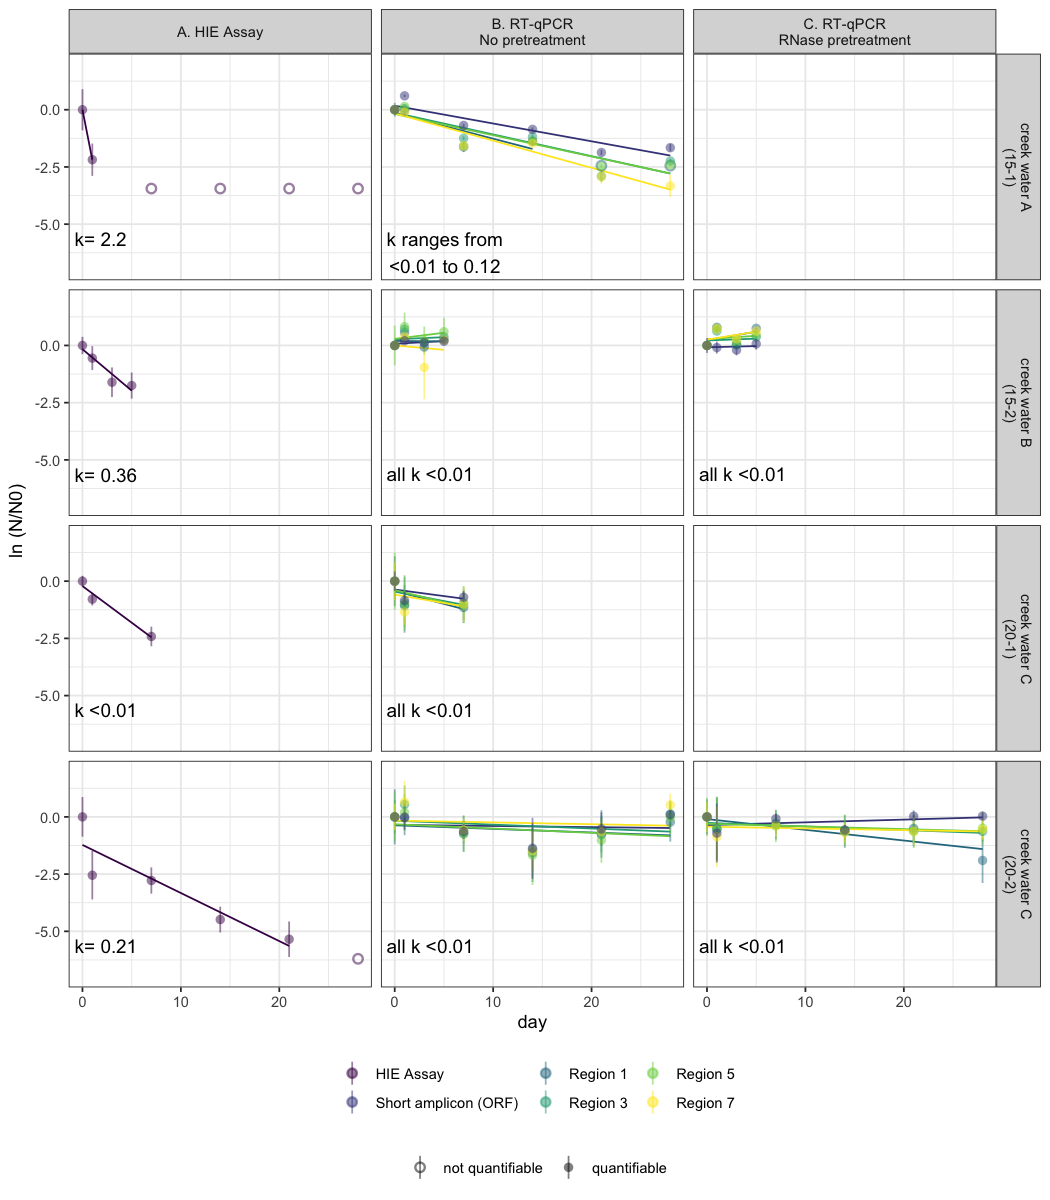

In [38]:
b=10
options(repr.plot.width =b*((half.col_w)/(max_h/1.5)), repr.plot.height = b) #change the size of the plot

a<-df
a[a$RNase_treated=="N","RNase_treated"]<-"B. RT-qPCR\nNo pretreatment"
a[a$RNase_treated=="Y","RNase_treated"]<-"C. RT-qPCR\nRNase pretreatment"
a[a$target=="HIE Assay","RNase_treated"]<-"A. HIE Assay"
a[a$target=="ORF","target_region"]<-"Short amplicon (ORF)"
a[a$target_region =="1", "target_region"]<- "Region 1"
a[a$target_region =="3", "target_region"]<- "Region 3"
a[a$target_region =="5", "target_region"]<- "Region 5"
a[a$target_region =="7", "target_region"]<- "Region 7"
a[a$target_region=="HIE Assay","target_region"]<-"HIE Assay"
a$target_region<-factor(a$target_region, levels=c("HIE Assay","Short amplicon (ORF)", "Region 1","Region 3","Region 5","Region 7"))

a[a$experiment == "1", "experiment"]<- "creek water A\n(15-1)"
a[a$experiment == "2", "experiment"]<- "creek water B\n(15-2)"
a[(a$experiment == "3"),"experiment"]<- "creek water C\n(20-1)"
a[(a$experiment == "4"), "experiment"]<- "creek water C\n(20-2)"
a$experiment=factor(a$experiment, levels=c("creek water A\n(15-1)", "creek water B\n(15-2)", "creek water C\n(20-1)",  "creek water C\n(20-2)"))
names(a)[names(a) == 'mean_lnNN0'] <- 'lnNN0'
a$day<- as.numeric(a$day)
a[a$bdl=="not quantifiable","std_lnNN0"]<-0
                   
g<-ggplot(a, aes(x=day))+
    geom_line(aes(y=fit, color=target_region), show.legend=FALSE)+
    geom_pointrange(aes(y=lnNN0,ymin= lnNN0 -std_lnNN0, ,ymax= lnNN0 +std_lnNN0, color=target_region, shape=bdl ), size=0.5, alpha=0.5)+
    ylab("ln (N/N0)")+
    xlab("day")+
    guides(col=guide_legend(""))+
    # scale_color_manual(values=c("#E9D539FF","#467EF4FF","#83FF52FF", "#30123BFF","#FEAA33FF"))+ 
    scale_color_viridis_d()+
    scale_shape_manual(values=c(1,16))+
    guides( shape=guide_legend(""))+
    facet_grid(experiment~RNase_treated)+
    theme_bw()+
    ylim(-7,2)+ 
    theme(legend.position= "bottom", legend.box='vertical')

dfl<-unique(a[,c("experiment","k","target","target_region", "RNase_treated")])
dfl$bdl<-"quantifiable"
dfl$k<-signif(dfl$k,2)
dfl<-  dfl  %>% group_by(RNase_treated,experiment)%>% summarize(mink= min(k), maxk=max(k),  n=n())
dfl<- dfl%>% mutate(Label=paste("k = ",mink, sep=""))
dfl$mink <-as.character(dfl$mink)
dfl$maxk <-as.character(dfl$maxk)
dfl[dfl$mink ==0.01, "mink"]<- "<0.01"
dfl[dfl$maxk ==0.01, "maxk"]<- "<0.01"
dfl<- dfl%>%  mutate(Label=paste("k ranges from\n",mink," to ",maxk, sep="")) 
dfl[(dfl$maxk ==dfl$mink)&(dfl$mink=="<0.01")&((dfl$RNase_treated!="A. HIE Assay")|(dfl$n!=1)), "Label"]<- "all k <0.01"
dfl[(dfl$maxk ==dfl$mink)&(dfl$mink=="<0.01")&((dfl$RNase_treated=="A. HIE Assay")|(dfl$n==1)), "Label"]<- "k <0.01"
dfl[(dfl$maxk ==dfl$mink)&(dfl$mink!="<0.01"), "Label"]<- dfl[(dfl$maxk ==dfl$mink)&(dfl$mink!="<0.01"), "mink"]
dfl<-dfl  %>% mutate(Label = case_when(((maxk ==mink)&(mink!="<0.01")) ~ paste0("k= ", Label),TRUE ~ paste0("", Label)))

dfl$target_region<- "Short amplicon (ORF)"
dfl$target<-"ORF"
dfl$bdl<-"quantifiable"

dfl<-dfl[dfl$target_region %in% c("Short amplicon (ORF)","HIE Assay"),]
# g + geom_text(data=dfl,aes(x=-Inf,y=-Inf,label=Label),
# hjust = -0.1,vjust=-0.5, size=5)#,check_overlap = T)
g + geom_text_repel(data=dfl,aes(x=1,y=-5,label=Label),size=4, direction="y", segment.color = "transparent",seed=11, alpha=1)



ggsave(paste0(path_f,"Figure_1.jpg"),  units='mm',device= 'jpg',width=half.col_w, height=max_h/1.5)

In [39]:
a[a$bdl=="not quantifiable",] #difficult to show on the plot but the last two points for MK1 expt 1 were BDL, T0 varried for all assays so even through  it plots in the

id,low_conc,storage_condition,filtered,RNase_treated,experiment,time_point,day,target,target_region,conc,lnNN0,std_lnNN0,bdl,lower_limit_log,k,fit,lwr,upr
<chr>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
15A5F,6000,15,F,B. RT-qPCR No pretreatment,creek water A (15-1),T21,21,MK1,Region 1,3000,-2.445332,0,not quantifiable,-1.752185,0.0100000,NA,NA,NA
15A5F,6000,15,F,B. RT-qPCR No pretreatment,creek water A (15-1),T28,28,MK1,Region 1,3000,-2.445332,0,not quantifiable,-1.752185,0.0100000,NA,NA,NA
15A5F,26800,15,F,A. HIE Assay,creek water A (15-1),T14,14,HIE Assay,HIE Assay,13400,-3.443891,0,not quantifiable,-2.750744,2.1841979,NA,NA,NA
15A5F,26800,15,F,A. HIE Assay,creek water A (15-1),T21,21,HIE Assay,HIE Assay,13400,-3.443891,0,not quantifiable,-2.750744,2.1841979,NA,NA,NA
15A5F,26800,15,F,A. HIE Assay,creek water A (15-1),T28,28,HIE Assay,HIE Assay,13400,-3.443891,0,not quantifiable,-2.750744,2.1841979,NA,NA,NA
15A5F,26800,15,F,A. HIE Assay,creek water A (15-1),T7,7,HIE Assay,HIE Assay,13400,-3.443891,0,not quantifiable,-2.750744,2.1841979,NA,NA,NA
NA,NA,20,F,A. HIE Assay,creek water C (20-2),T28,28,HIE Assay,HIE Assay,13400,-6.200655,0,not quantifiable,-5.507508,0.2101754,NA,NA,NA


### Multiple regression

In [40]:
#HIE assay testing

base<-df[(df$target=="HIE Assay"),]
base<-base[base$bdl =="quantifiable",]

base$t20<- 0
base[base$storage_condition ==20, "t20"]<-1

reg=lm(lnNN0~day + t20+ day:t20 , data=base)

summary(reg )

out<-tidy(reg,)
out<- as.data.frame(out)
stargazer(out,type="html", summary=FALSE, rownames=FALSE, digits=2, out=paste0(path_f,"Table_S8.doc"))


Call:
lm(formula = lnNN0 ~ day + t20 + day:t20, data = base)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.5297 -0.2942  0.2428  0.4685  0.7830 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept) -0.48515    0.45354  -1.070    0.310
day         -0.31882    0.18516  -1.722    0.116
t20         -0.29789    0.59494  -0.501    0.627
day:t20      0.08164    0.18945   0.431    0.676

Residual standard error: 0.8141 on 10 degrees of freedom
Multiple R-squared:  0.8226,	Adjusted R-squared:  0.7694 
F-statistic: 15.46 on 3 and 10 DF,  p-value: 0.0004387



<table style="text-align:center"><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">term</td><td>estimate</td><td>std.error</td><td>statistic</td><td>p.value</td></tr>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">(Intercept)</td><td>-0.49</td><td>0.45</td><td>-1.07</td><td>0.31</td></tr>
<tr><td style="text-align:left">day</td><td>-0.32</td><td>0.19</td><td>-1.72</td><td>0.12</td></tr>
<tr><td style="text-align:left">t20</td><td>-0.30</td><td>0.59</td><td>-0.50</td><td>0.63</td></tr>
<tr><td style="text-align:left">day:t20</td><td>0.08</td><td>0.19</td><td>0.43</td><td>0.68</td></tr>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr></table>


In [41]:
#ORF assay testing RNase

base<-df[(df$target != "HIE Assay"),]
base<-df[(df$RNase_treated == "N"),]
base<-base[base$bdl =="quantifiable",]

base$t20<- 0
base[base$storage_condition ==20, "t20"]<-1

reg=lm(lnNN0~day + t20+ day:t20 , data=base)

summary(reg)
out<-tidy(reg)
out<- as.data.frame(out)
stargazer(out,type="html", summary=FALSE, rownames=FALSE, digits=4, out=paste0(path_f,"Table_S9.doc"))


Call:
lm(formula = lnNN0 ~ day + t20 + day:t20, data = base)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.2967 -0.3658  0.0347  0.5974  1.7184 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.03317    0.15733   0.211 0.833430    
day         -0.10042    0.01452  -6.916 4.02e-10 ***
t20         -0.63054    0.23055  -2.735 0.007347 ** 
day:t20      0.07894    0.01978   3.991 0.000123 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9099 on 103 degrees of freedom
Multiple R-squared:  0.3313,	Adjusted R-squared:  0.3118 
F-statistic: 17.01 on 3 and 103 DF,  p-value: 4.79e-09



<table style="text-align:center"><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">term</td><td>estimate</td><td>std.error</td><td>statistic</td><td>p.value</td></tr>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">(Intercept)</td><td>0.0332</td><td>0.1573</td><td>0.2108</td><td>0.8334</td></tr>
<tr><td style="text-align:left">day</td><td>-0.1004</td><td>0.0145</td><td>-6.9161</td><td>0</td></tr>
<tr><td style="text-align:left">t20</td><td>-0.6305</td><td>0.2305</td><td>-2.7350</td><td>0.0073</td></tr>
<tr><td style="text-align:left">day:t20</td><td>0.0789</td><td>0.0198</td><td>3.9909</td><td>0.0001</td></tr>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr></table>


In [42]:
base<-df[(df$target != "HIE Assay"),]
base<-df[(df$RNase_treated == "N"),]
base<-base[base$bdl =="quantifiable",]

base$long_amplicon<- 0
base[base$target_region !="ORF", "long_amplicon"]<-1

reg=lm(lnNN0~day + long_amplicon + day:long_amplicon , data=base)

summary(reg)
out<-tidy(reg)
out<- as.data.frame(out)
stargazer(out,type="html", summary=FALSE, rownames=FALSE, digits=3, out=paste0(path_f,"Table_S10.doc"))


Call:
lm(formula = lnNN0 ~ day + long_amplicon + day:long_amplicon, 
    data = base)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7170 -0.4076  0.1694  0.4241  2.5884 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)  
(Intercept)       -0.06574    0.29478  -0.223   0.8240  
day               -0.04220    0.02335  -1.807   0.0737 .
long_amplicon     -0.24051    0.32357  -0.743   0.4590  
day:long_amplicon -0.02075    0.02607  -0.796   0.4280  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9619 on 103 degrees of freedom
Multiple R-squared:  0.2527,	Adjusted R-squared:  0.2309 
F-statistic: 11.61 on 3 and 103 DF,  p-value: 1.289e-06



<table style="text-align:center"><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">term</td><td>estimate</td><td>std.error</td><td>statistic</td><td>p.value</td></tr>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">(Intercept)</td><td>-0.066</td><td>0.295</td><td>-0.223</td><td>0.824</td></tr>
<tr><td style="text-align:left">day</td><td>-0.042</td><td>0.023</td><td>-1.807</td><td>0.074</td></tr>
<tr><td style="text-align:left">long_amplicon</td><td>-0.241</td><td>0.324</td><td>-0.743</td><td>0.459</td></tr>
<tr><td style="text-align:left">day:long_amplicon</td><td>-0.021</td><td>0.026</td><td>-0.796</td><td>0.428</td></tr>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr></table>


## 5. Plot k values and se (table k obs and genome-wide extrapolation)

Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”


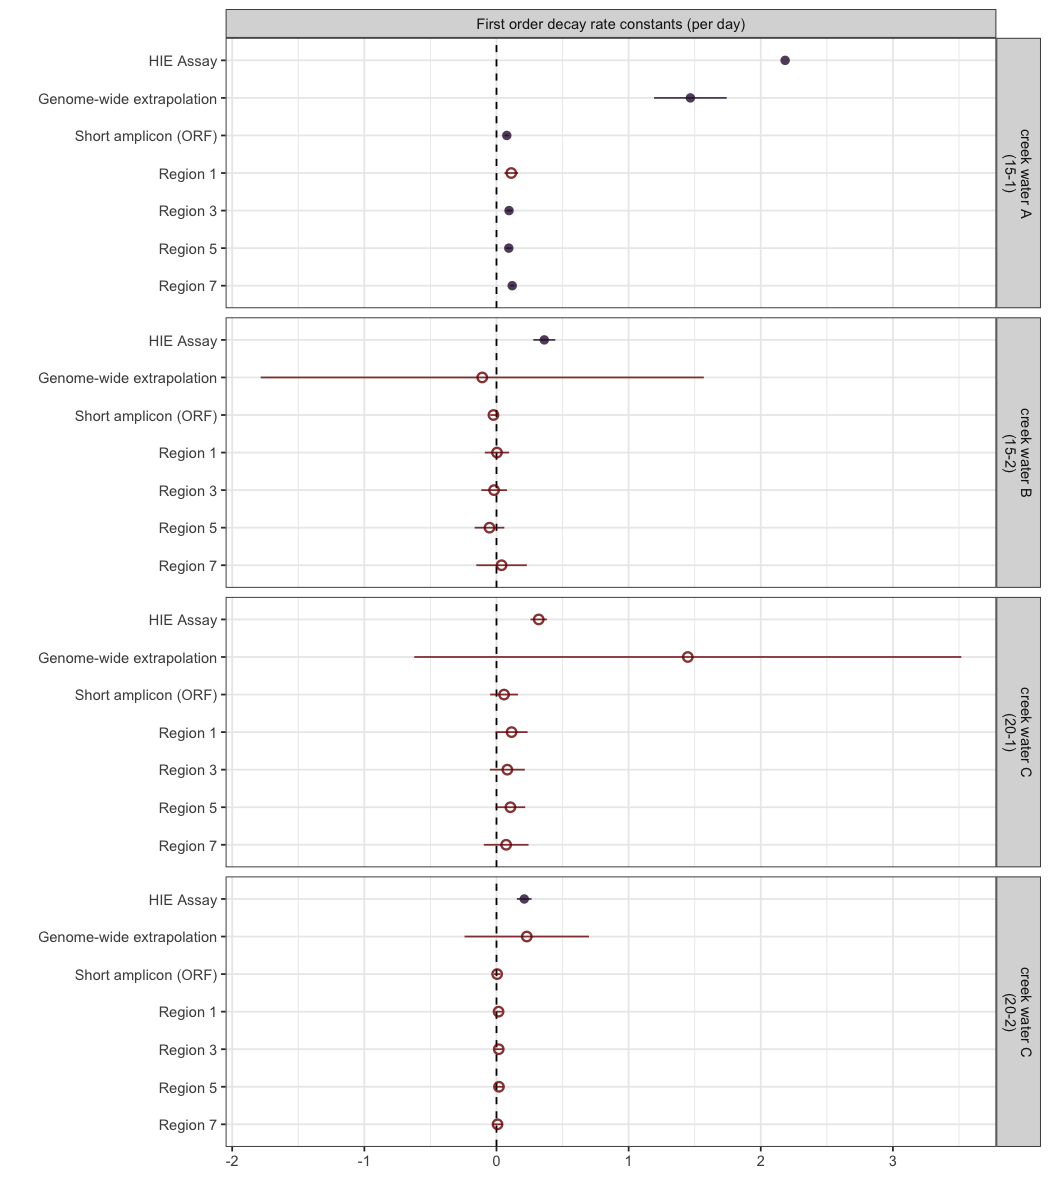

In [43]:
a<-kobs
a<-a[a$RNase_treated=="No pretreatment",]
a[a$target=="ORF","target_region"]<-"Short amplicon (ORF)"
a[a$target_region =="1", "target_region"]<- "Region 1"
a[a$target_region =="3", "target_region"]<- "Region 3"
a[a$target_region =="5", "target_region"]<- "Region 5"
a[a$target_region =="7", "target_region"]<- "Region 7"

a$target_region<-factor(a$target_region, levels=c("Region 7","Region 5","Region 3", "Region 1","Short amplicon (ORF)","Genome-wide extrapolation","HIE Assay"))
a[a$experiment == "15-1", "experiment"]<- "creek water A\n(15-1)"
a[a$experiment == "15-2", "experiment"]<- "creek water B\n(15-2)"
a[a$experiment == "20-1", "experiment"]<- "creek water C\n(20-1)"
a[a$experiment == "20-2", "experiment"]<- "creek water C\n(20-2)"
a$experiment=factor(a$experiment, levels=c("creek water A\n(15-1)", "creek water B\n(15-2)","creek water C\n(20-1)", "creek water C\n(20-2)"))
a$title<- "First order decay rate constants (per day)"         

g<-ggplot(a, aes(y=target_region))+
    geom_vline(xintercept=0, linetype='dashed')+
    geom_pointrange(aes(x=k_plot,xmin=k_lwr,xmax= k_upr, shape=not_signif, color=not_signif , fill=not_signif),alpha=0.8)+
    ylab("")+
    xlab("")+
    guides(col=guide_legend(""))+
    # scale_color_manual(values=c("#E9D539FF","#467EF4FF","#83FF52FF", "#30123BFF","#FEAA33FF"))+ 
    scale_shape_manual(values=c(16,1))+
    scale_color_viridis_d(option="turbo")+
    guides( shape=guide_legend(""))+
    facet_grid(experiment~title, scales="free_y", space="free_y")+
    theme_bw()+
    theme(legend.position= "none", legend.box='vertical')
g

ggsave(paste0(path_f,"Figure_2.jpg"),  units='mm',device= 'jpg',width=half.col_w, height=max_h/1.5)

# Absorbance Plot

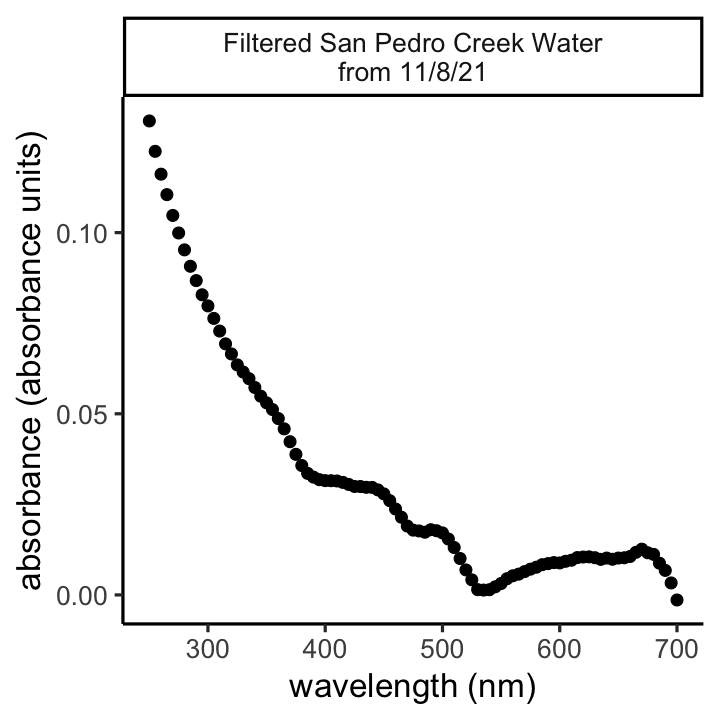

In [44]:
absorbance_l<-  gather(absorbance, matrix, absorbance, San_Pedro_Creek_0.22um_F_abs)

options(repr.plot.width =6, repr.plot.height = 6) #change the size of the plot
theme_set(theme_classic(base_size=20))# set font size

a<-absorbance_l
a[a$matrix==  "San_Pedro_Creek_0.22um_F_abs", "matrix"]<-"Filtered San Pedro Creek Water\nfrom 11/8/21"
a[a$matrix==  "San_Pedro_Creek_Raw_abs", "matrix"]<-"Raw San Pedro Creek Water\nfrom 11/8/21"

g<- ggplot(a, aes(x=Wavelength_nm, y=absorbance))+
    geom_point(size=3)+
    xlab("wavelength (nm)")+
    ylab("absorbance (absorbance units)")+
    scale_color_viridis_d()+
    facet_wrap(~matrix,ncol=1)+
    theme(legend.position= "none")

g
ggsave(paste0(path_f,"Figure_S2.jpg"),  units='mm',device= 'jpg',width=half.col_w, height=max_h/2)
